# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

In [1]:
17

17

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [2]:
import math
import time
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import make_column_selector, ColumnTransformer, make_column_transformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, TargetEncoder, StandardScaler
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV, HalvingGridSearchCV, HalvingRandomSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KernelDensity
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix, mean_squared_error, roc_curve, make_scorer, classification_report, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

# Suppress all warnings globally
warnings.filterwarnings(action='ignore')

pd.set_option('display.max_columns', 75)

In [3]:
# df = pd.read_csv('data/bank-additional-full.csv', sep = ';')
df = pd.read_csv('data/bank-additional.csv', sep = ';')

In [4]:
df.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,487,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,346,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,227,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,17,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,58,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


In [5]:
df.shape

(4119, 21)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4119 non-null   int64  
 1   job             4119 non-null   object 
 2   marital         4119 non-null   object 
 3   education       4119 non-null   object 
 4   default         4119 non-null   object 
 5   housing         4119 non-null   object 
 6   loan            4119 non-null   object 
 7   contact         4119 non-null   object 
 8   month           4119 non-null   object 
 9   day_of_week     4119 non-null   object 
 10  duration        4119 non-null   int64  
 11  campaign        4119 non-null   int64  
 12  pdays           4119 non-null   int64  
 13  previous        4119 non-null   int64  
 14  poutcome        4119 non-null   object 
 15  emp.var.rate    4119 non-null   float64
 16  cons.price.idx  4119 non-null   float64
 17  cons.conf.idx   4119 non-null   f

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [7]:
df.duplicated().sum()

0

In [8]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000
mean,40.113620,256.788055,2.537266,960.422190,0.190337,0.084972,93.579704,-40.499102,3.621356,5166.481695
std,10.313362,254.703736,2.568159,191.922786,0.541788,1.563114,0.579349,4.594578,1.733591,73.667904
min,18.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.635000,4963.600000
25%,32.000000,103.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.334000,5099.100000
50%,38.000000,181.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.000000,317.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,88.000000,3643.000000,35.000000,999.000000,6.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [10]:
df.describe(include=[object])

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,4119,4119,4119,4119,4119,4119,4119,4119,4119,4119,4119
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,1012,2509,1264,3315,2175,3349,2652,1378,860,3523,3668


In [11]:
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [12]:
df.nunique()

age                67
job                12
marital             4
education           8
default             3
housing             3
loan                3
contact             2
month              10
day_of_week         5
duration          828
campaign           25
pdays              21
previous            7
poutcome            3
emp.var.rate       10
cons.price.idx     26
cons.conf.idx      26
euribor3m         234
nr.employed        11
y                   2
dtype: int64

In [13]:
unique_objects = {}

for column in df.columns:
    if df[column].dtype == 'object':
        unique_objects[column] = list(df[column].unique())

unique_objects

{'job': ['blue-collar',
  'services',
  'admin.',
  'entrepreneur',
  'self-employed',
  'technician',
  'management',
  'student',
  'retired',
  'housemaid',
  'unemployed',
  'unknown'],
 'marital': ['married', 'single', 'divorced', 'unknown'],
 'education': ['basic.9y',
  'high.school',
  'university.degree',
  'professional.course',
  'basic.6y',
  'basic.4y',
  'unknown',
  'illiterate'],
 'default': ['no', 'unknown', 'yes'],
 'housing': ['yes', 'no', 'unknown'],
 'loan': ['no', 'unknown', 'yes'],
 'contact': ['cellular', 'telephone'],
 'month': ['may',
  'jun',
  'nov',
  'sep',
  'jul',
  'aug',
  'mar',
  'oct',
  'apr',
  'dec'],
 'day_of_week': ['fri', 'wed', 'mon', 'thu', 'tue'],
 'poutcome': ['nonexistent', 'failure', 'success'],
 'y': ['no', 'yes']}

<Figure size 4000x4000 with 0 Axes>

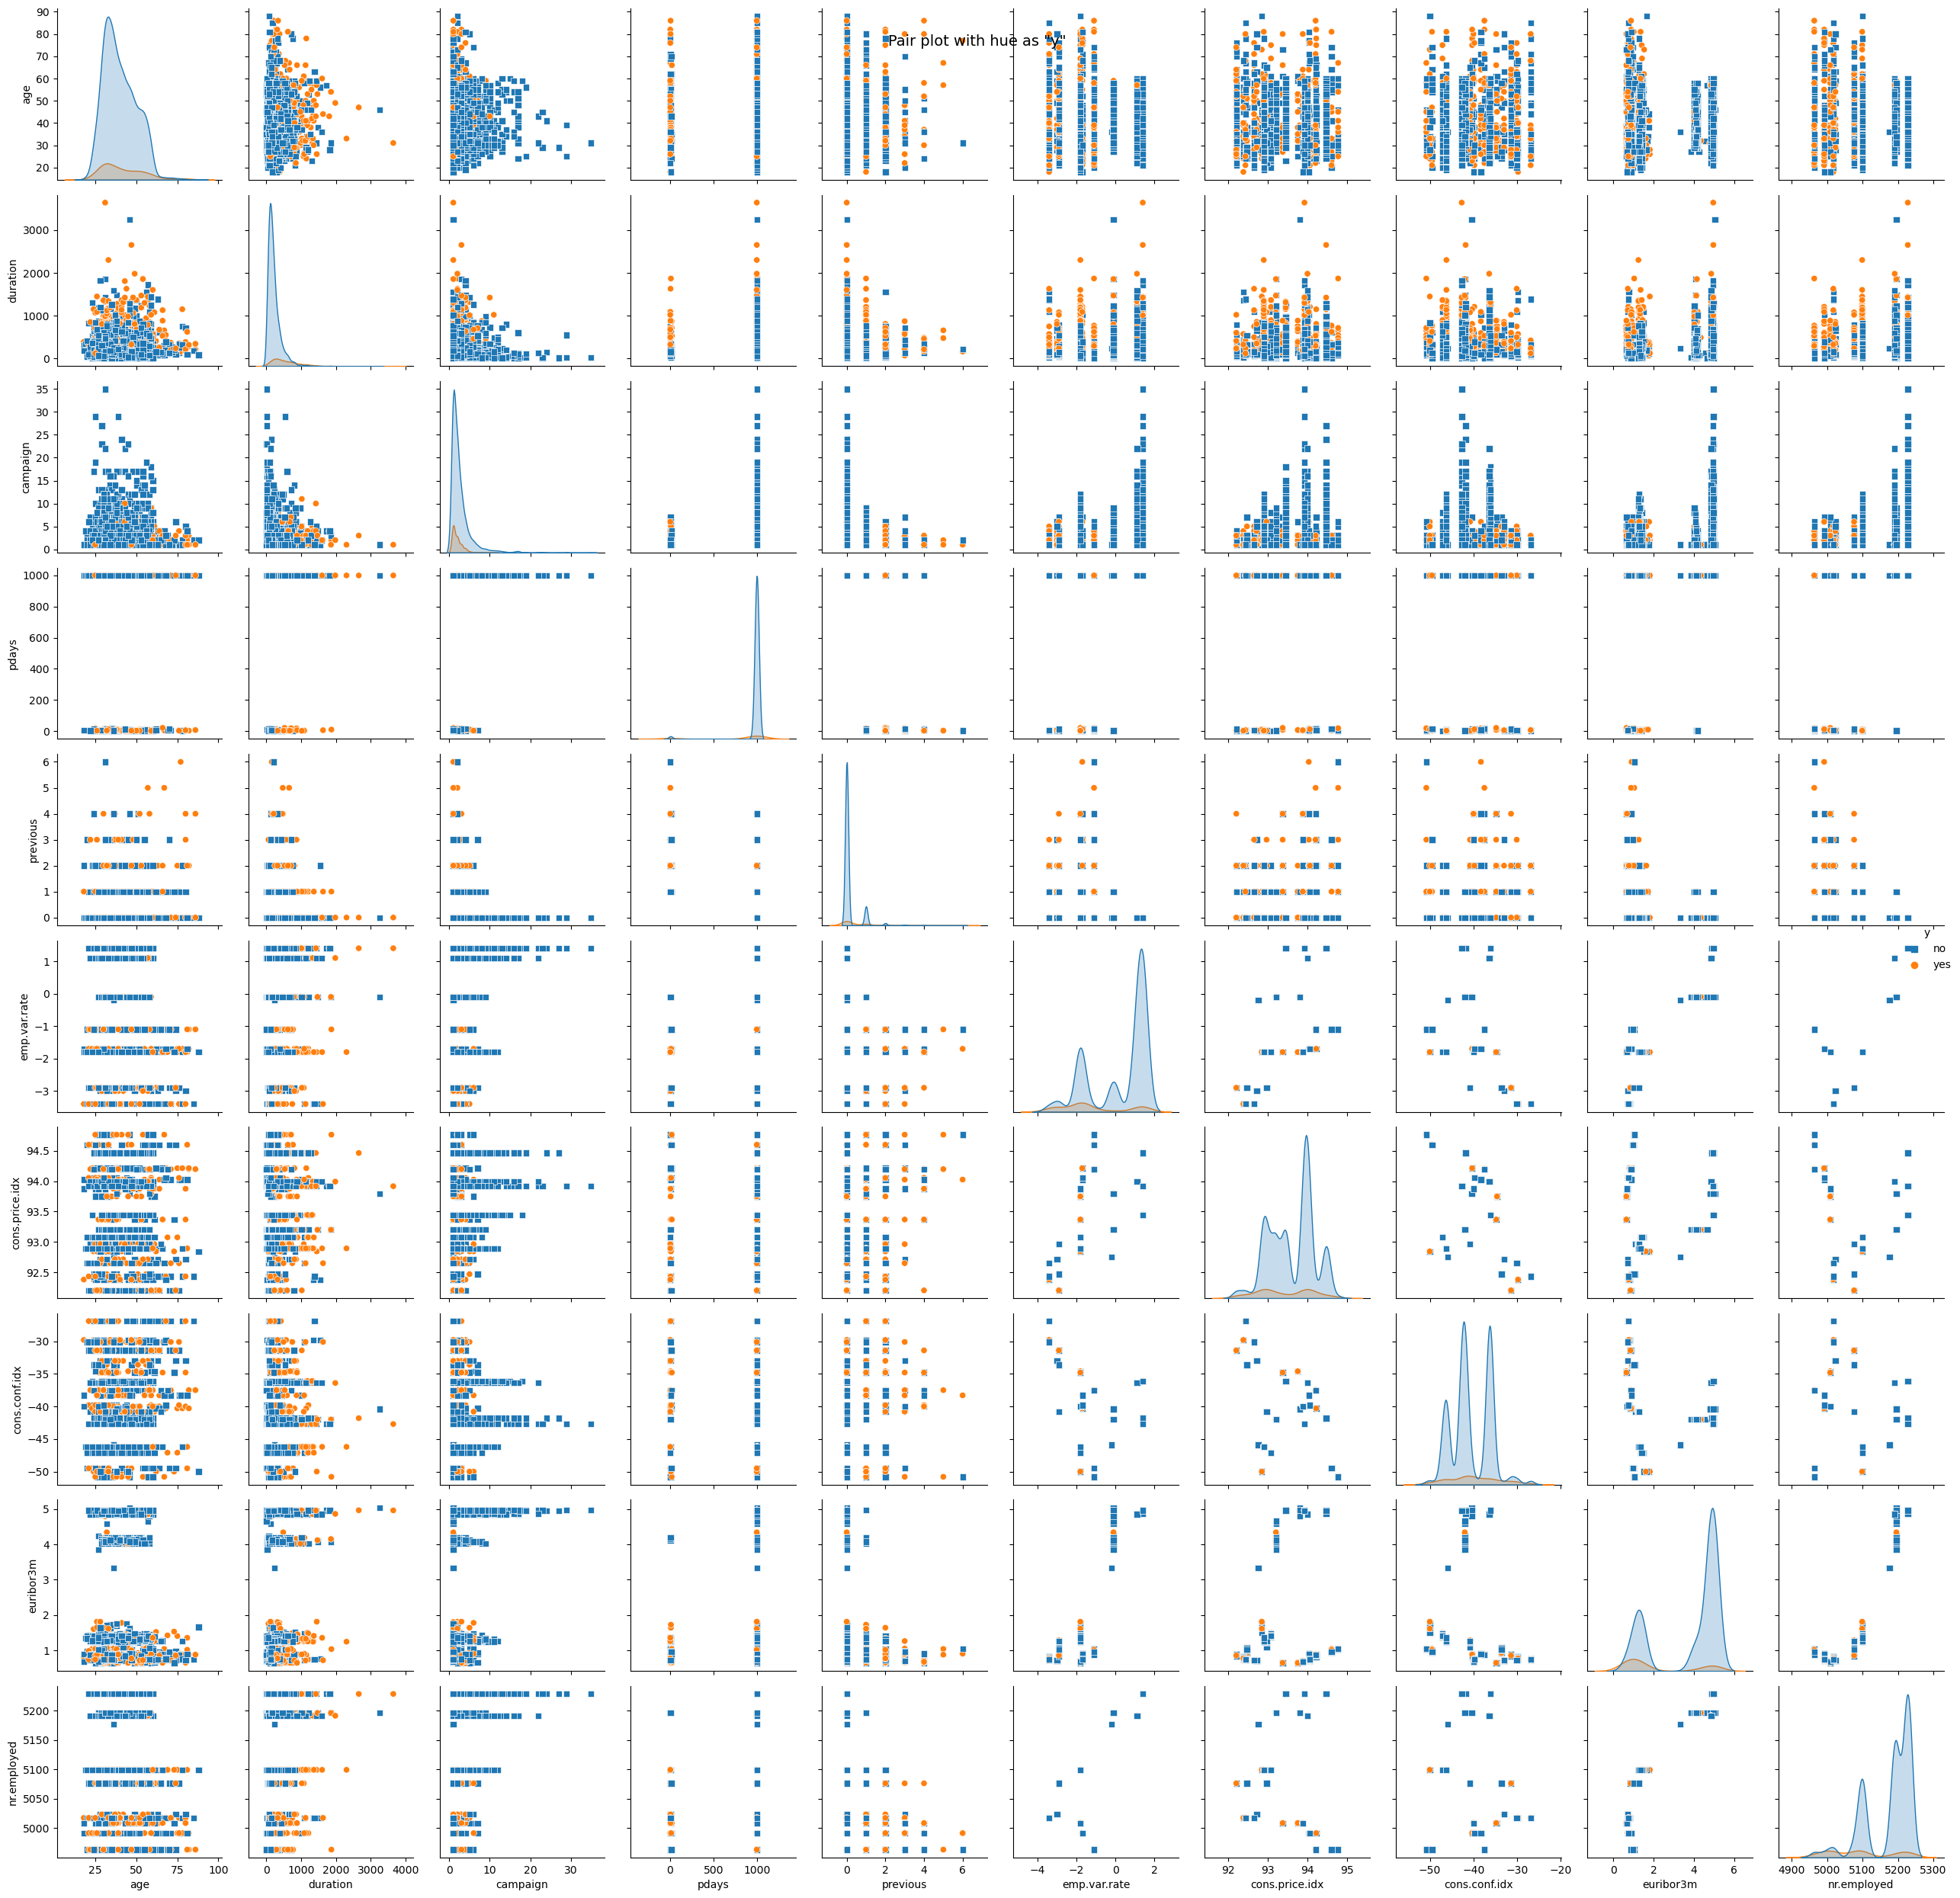

In [14]:
plt.figure(figsize=(40, 40))
sns.pairplot(df, diag_kind='kde', hue='y', markers=['s', 'o'])
plt.tight_layout()
plt.suptitle('Pair plot with hue as "y"', fontsize=14)
plt.savefig('images/piarplot.png')
plt.show()

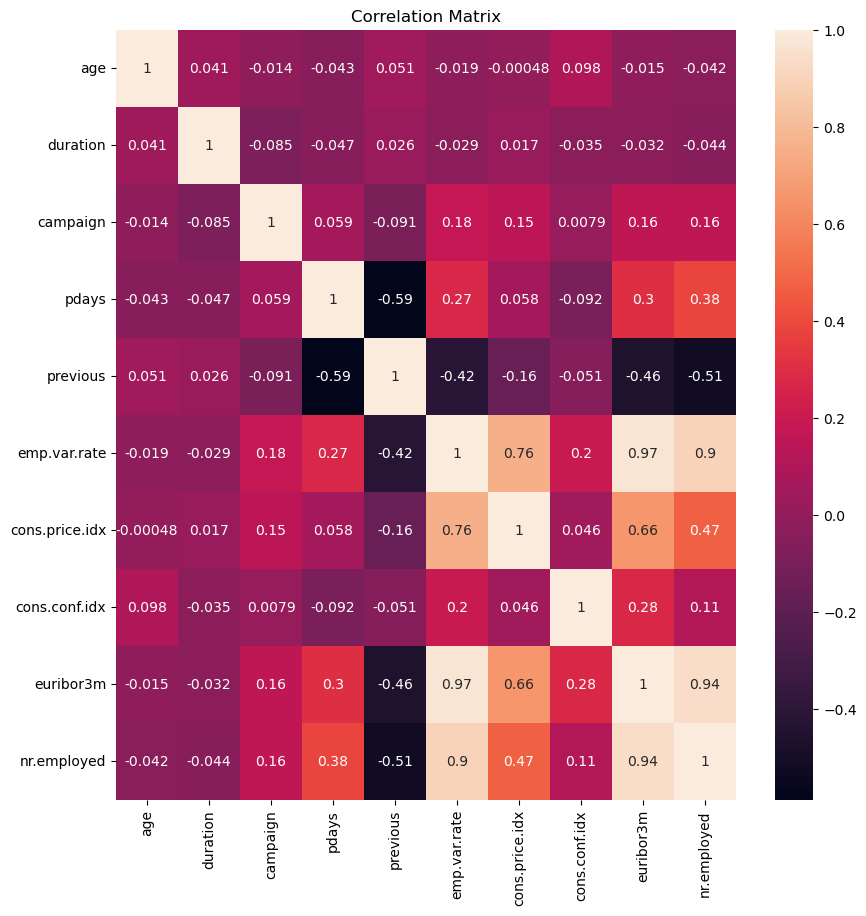

In [14]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(numeric_only=True), annot=True)
plt.title('Correlation Matrix')
plt.savefig('images/correlation_matrix.png')
plt.show()

In [15]:
# Getting numerical and categorical columns
numerical_columns = []
categorical_columns = []
for column in df.columns:
    if df[column].dtype == 'int64' or df[column].dtype == 'float64':
        numerical_columns.append(column)
    else:
        categorical_columns.append(column)


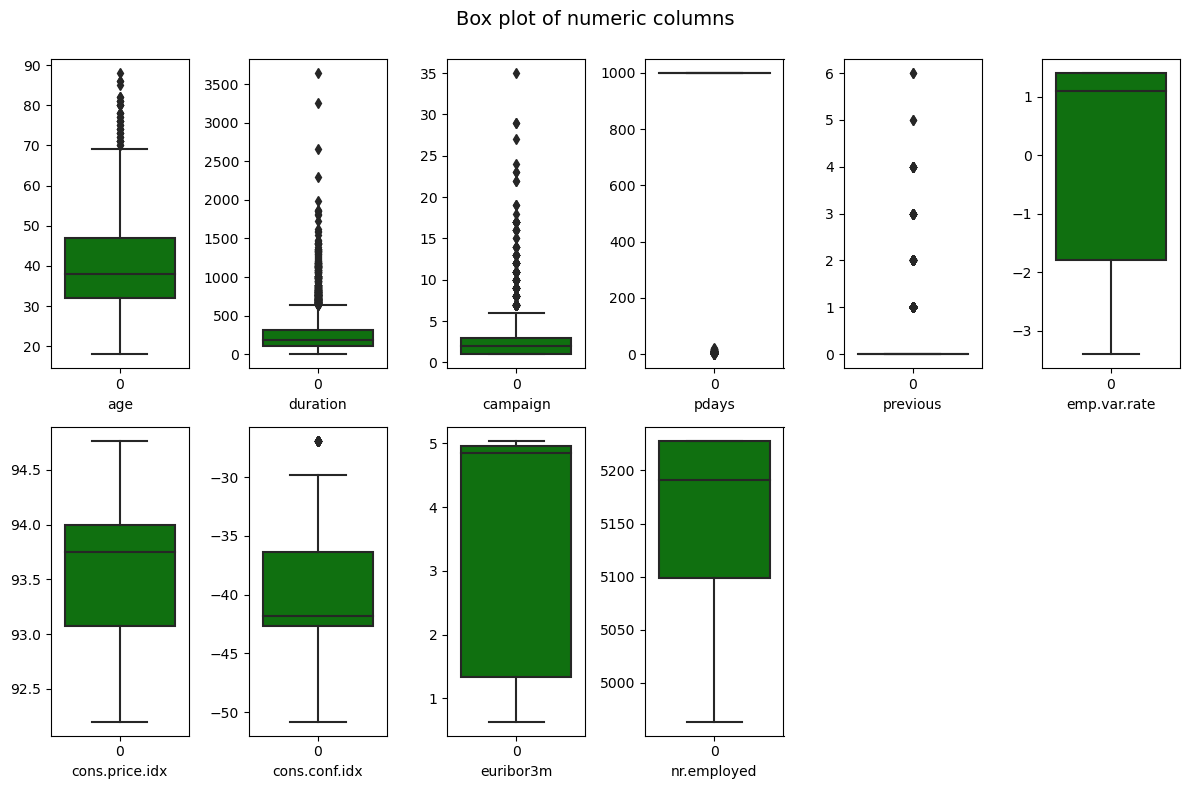

In [16]:
# Box plots for numerical columns
subplt_columns = 6
subplt_rows = math.ceil(len(numerical_columns) / subplt_columns)

plt.figure(figsize=(2 * subplt_columns, 4 * subplt_rows))

for i, column in enumerate(numerical_columns, start=1):
    plt.subplot(subplt_rows, subplt_columns, i)
    sns.boxplot(df[column], orient='v', color='green')
    plt.xlabel(column)
plt.suptitle(f'Box plot of numeric columns', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig('images/box_plot_numericals.png')
plt.show()

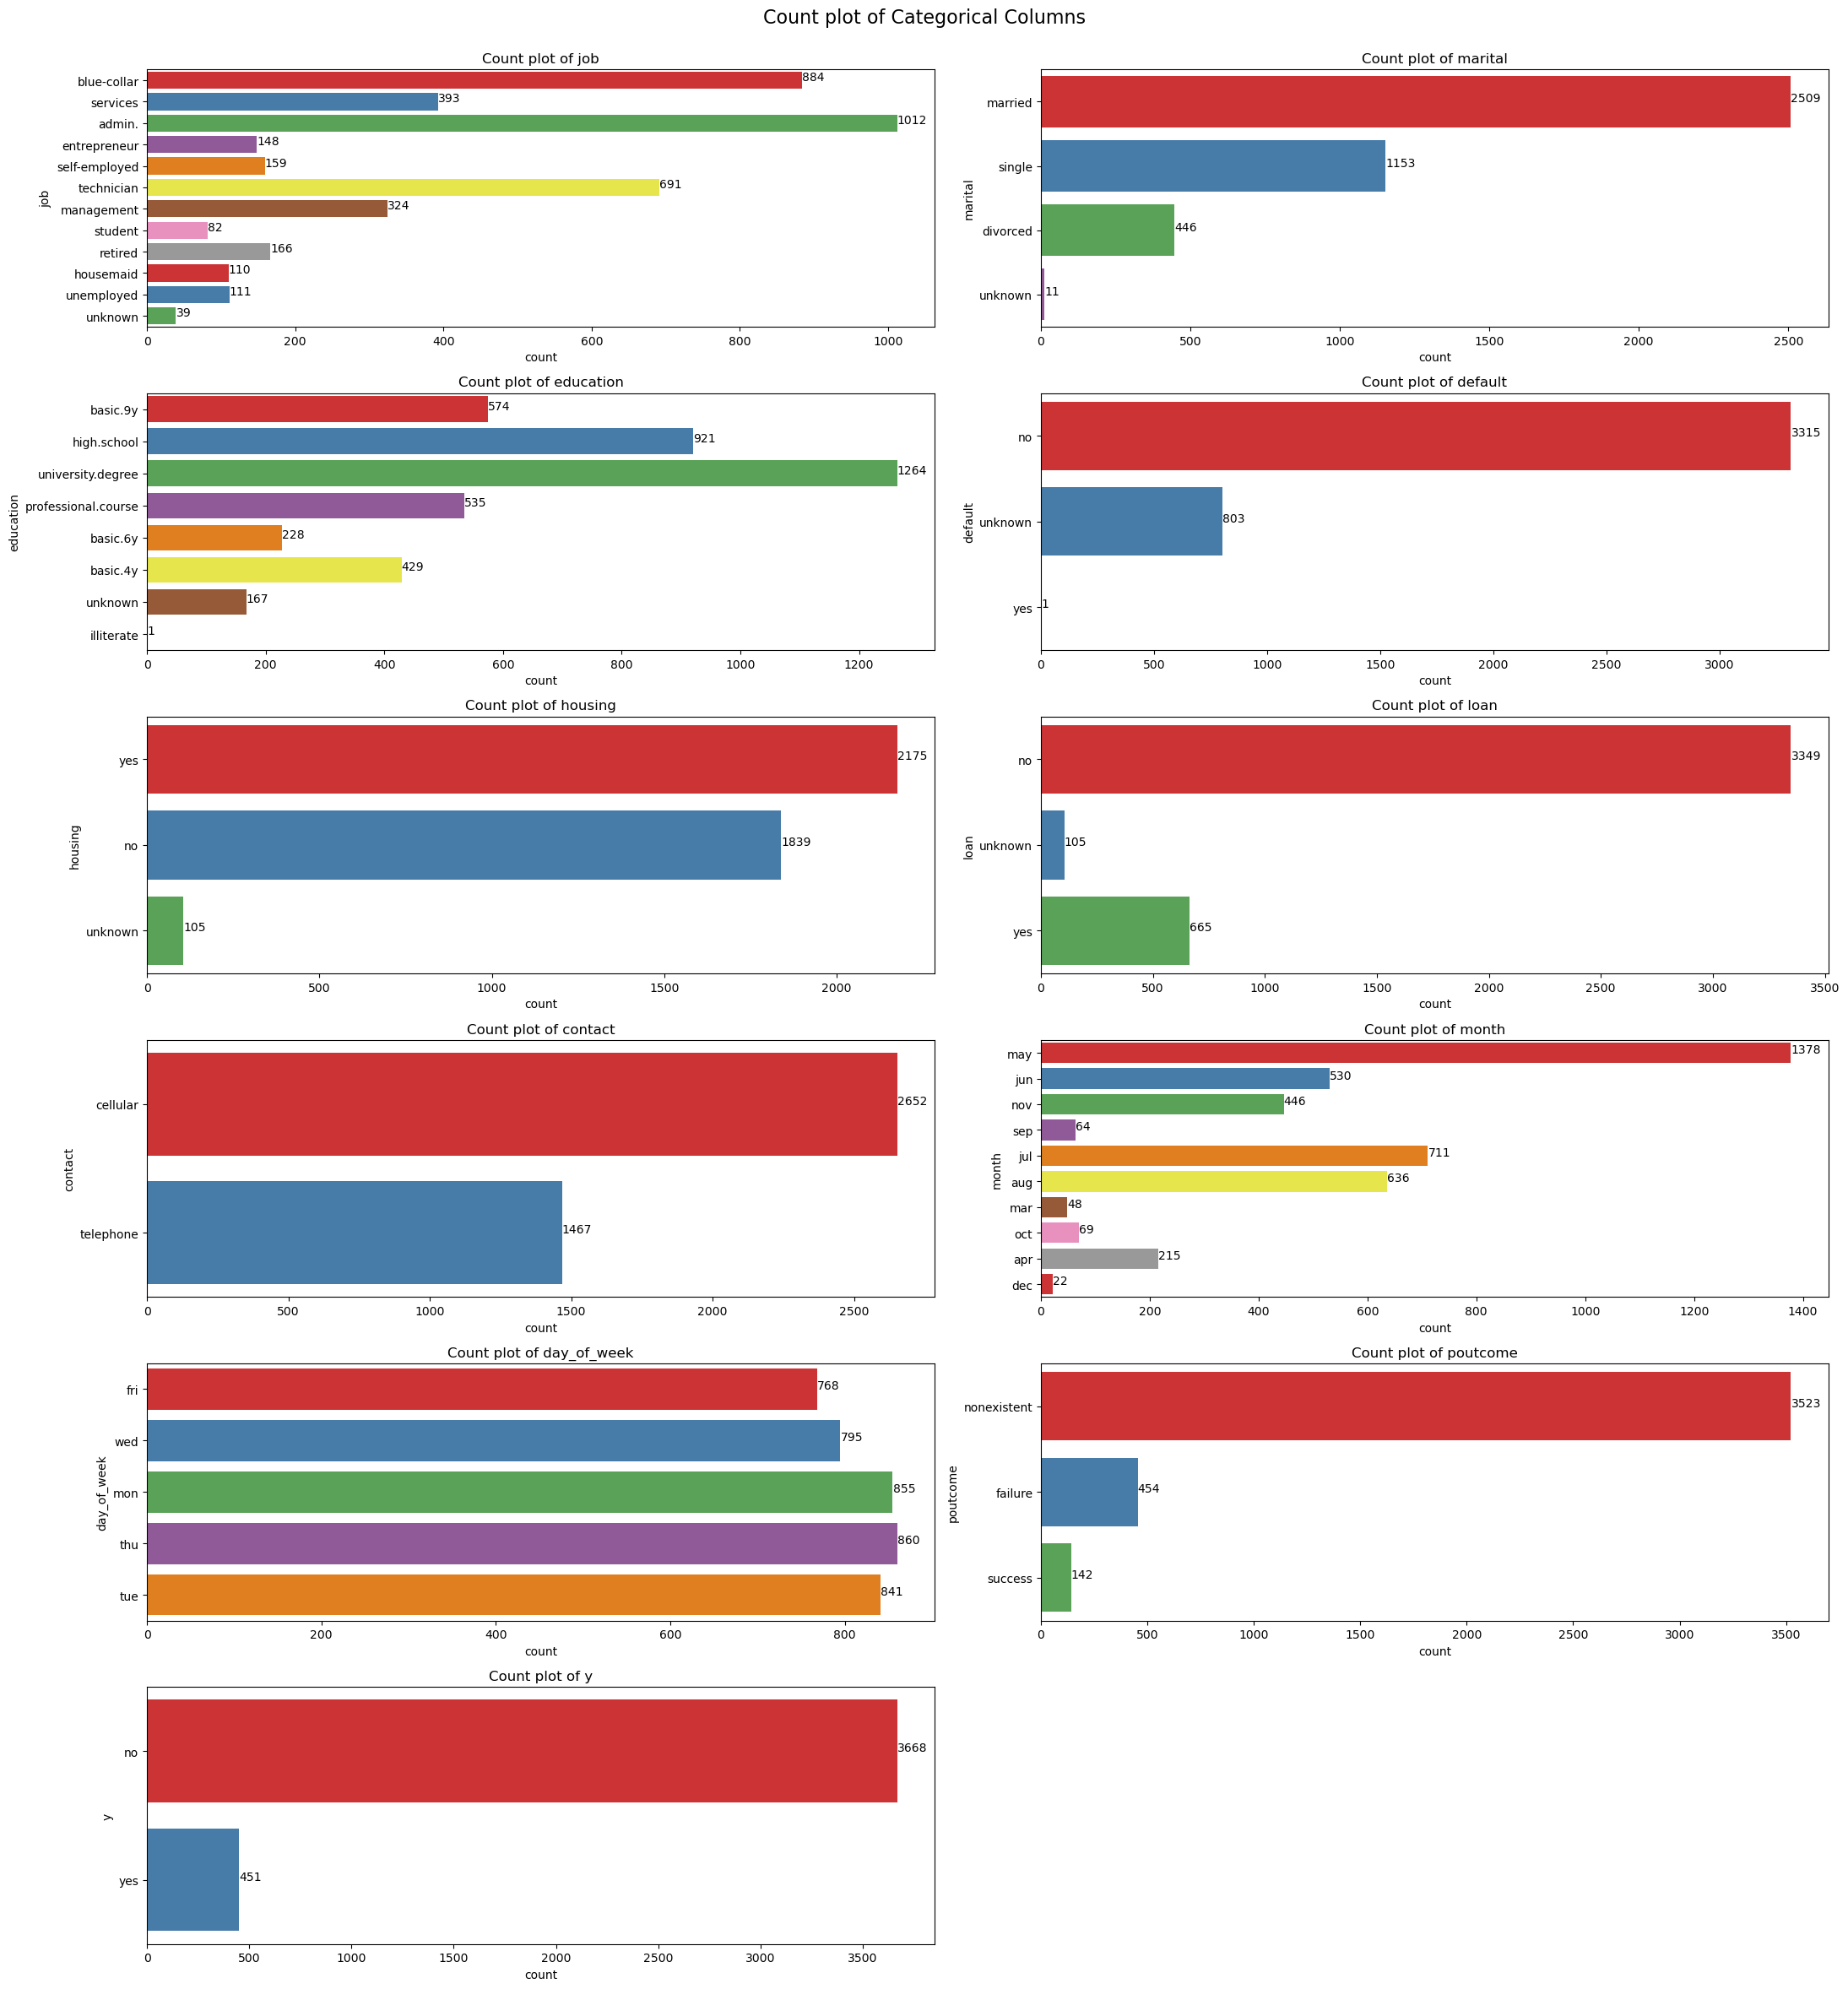

In [17]:

subplt_columns = 2
subplt_rows = math.ceil(len(categorical_columns) / subplt_columns)
plt.figure(figsize=(11 * subplt_columns, 4 * subplt_rows))

for i, column in enumerate(categorical_columns, 1):
    plt.subplot(subplt_rows, subplt_columns, i)
    ax = sns.countplot(y=df[column], palette='Set1')
    plt.title(f'Count plot of {column}')
    
    # Annotate each bar with the value
    for p in ax.patches:
        width = p.get_width()
        ax.annotate(f'{width:.0f}', 
                    (width + 0.1, p.get_y() + p.get_height() / 2)
                   )

plt.suptitle('Count plot of Categorical Columns', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig('images/countplot_categoricals.png')
plt.show()


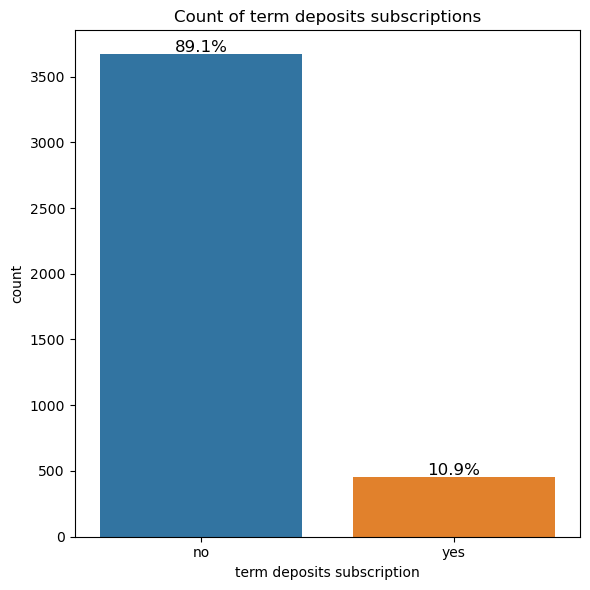

In [18]:
plt.figure(figsize=(6,6))
ax = sns.countplot(data=df, x='y')
plt.title('Count of term deposits subscriptions')
plt.xlabel('term deposits subscription')
total = len(df['y'])
for p in ax.patches:
    height = p.get_height()
    percentage = f'{100 * height / total:.1f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

# Save and show the plot
plt.tight_layout()
plt.savefig('images/term_deposit_subscribe.png')
plt.show()


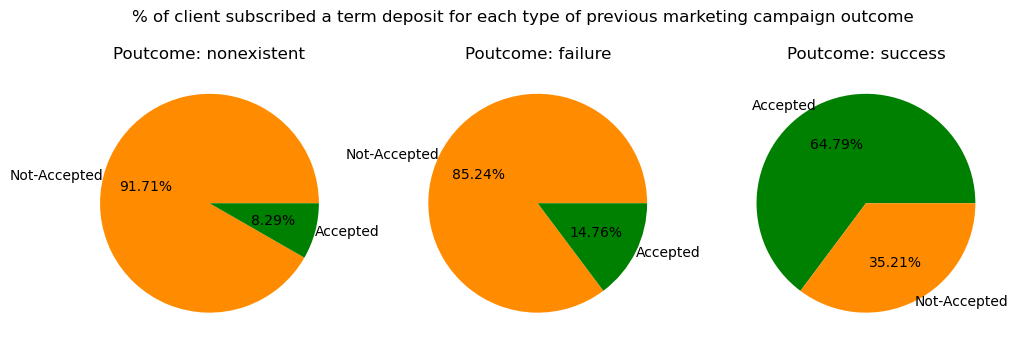

In [19]:
# poutcome (previous campaign outcome) vs has the client subscribed a term deposit
poutcomes = list(df['poutcome'].unique())
color_map = {'Accepted': 'green', 'Not-Accepted': 'darkorange'}
pieplot_columns = 3
pieplot_rows = math.ceil( len(poutcomes) / pieplot_columns)
plt.figure(figsize=(4 * pieplot_columns, 4 * pieplot_rows))
for i, poutcome in enumerate(poutcomes, start=1):
    plt.subplot(pieplot_rows, pieplot_columns, i)
    data = df[df['poutcome'] == poutcome]['y'].value_counts()
    labels = data.index.map({'yes': 'Accepted', 'no': 'Not-Accepted'})
    colors = [color_map[label] for label in labels]
    plt.pie(data, labels=labels, colors=colors, autopct='%1.2f%%', labeldistance=1)
    plt.title(f'Poutcome: {poutcome}', loc='center')
plt.suptitle('% of client subscribed a term deposit for each type of previous marketing campaign outcome')
plt.savefig('images/pieplot_termDeposit_vs_poutcome.png')
plt.show()

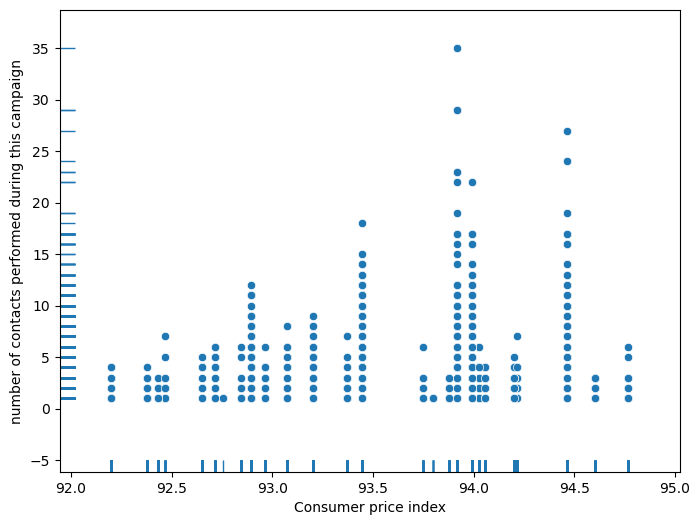

In [20]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='cons.price.idx', y='campaign')
sns.rugplot(data=df, x='cons.price.idx', y='campaign')
plt.xlabel('Consumer price index')
plt.ylabel('number of contacts performed during this campaign')
plt.savefig('images/scatter_cons_price_idx_vs_campaign.png')
plt.show()

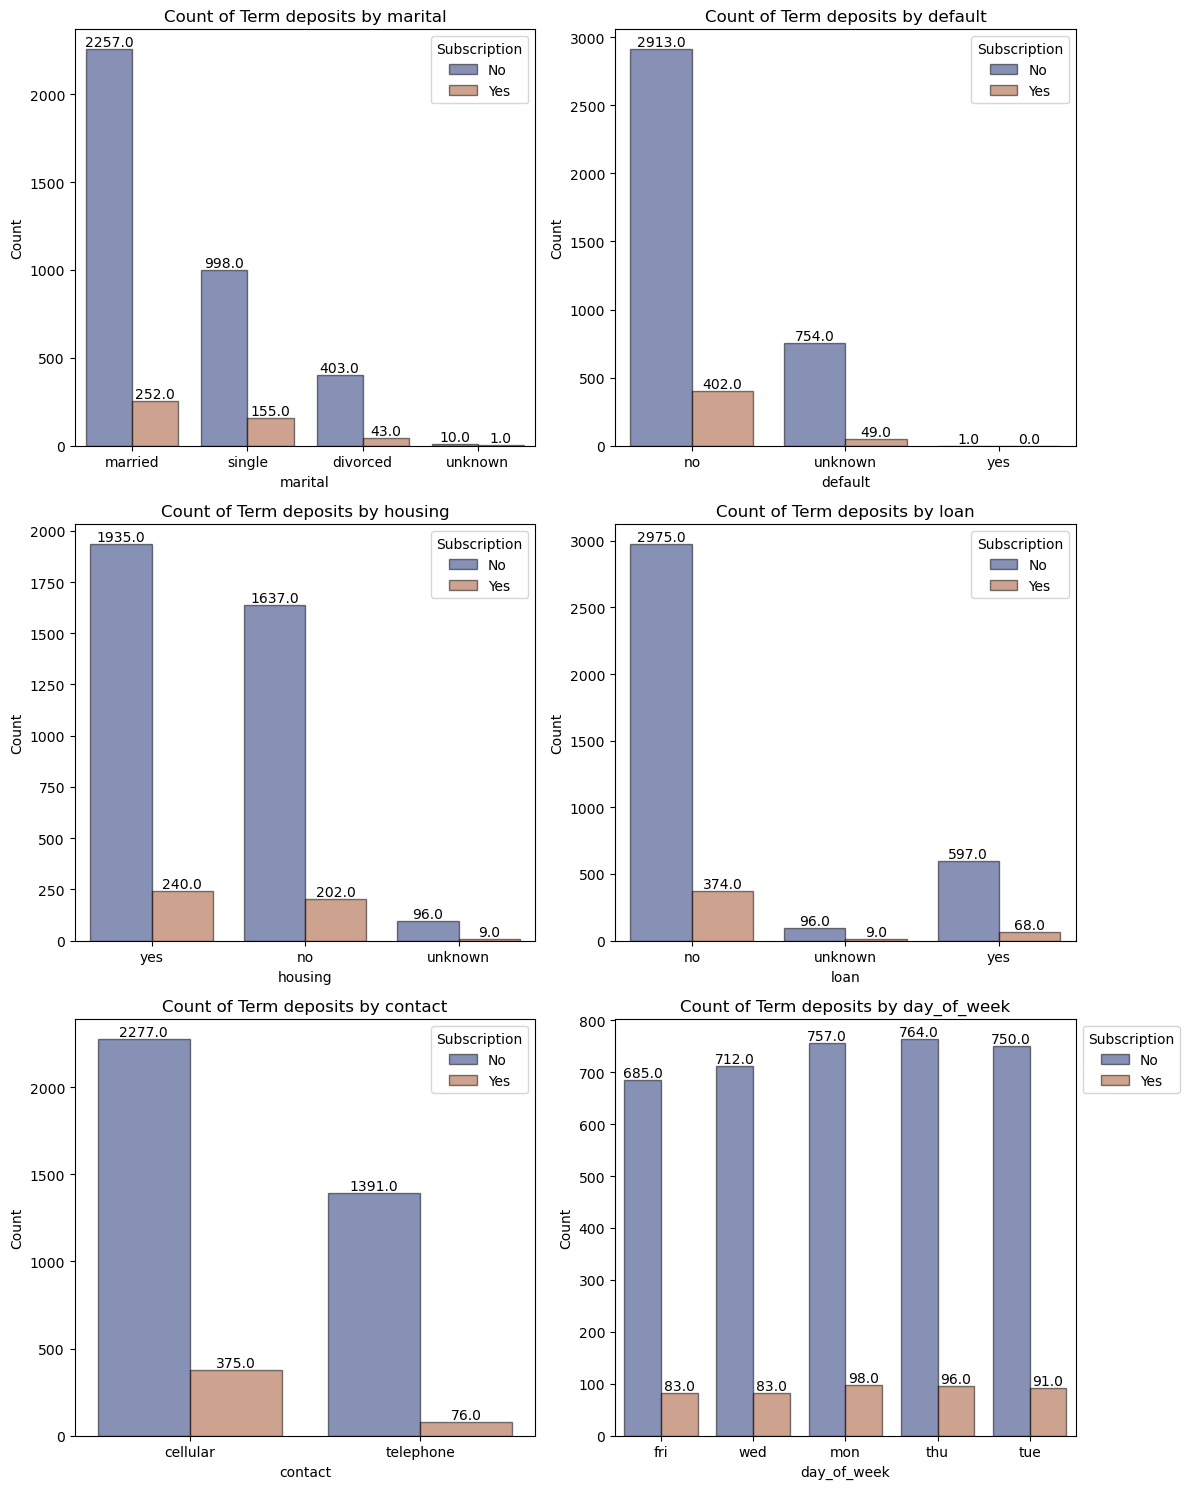

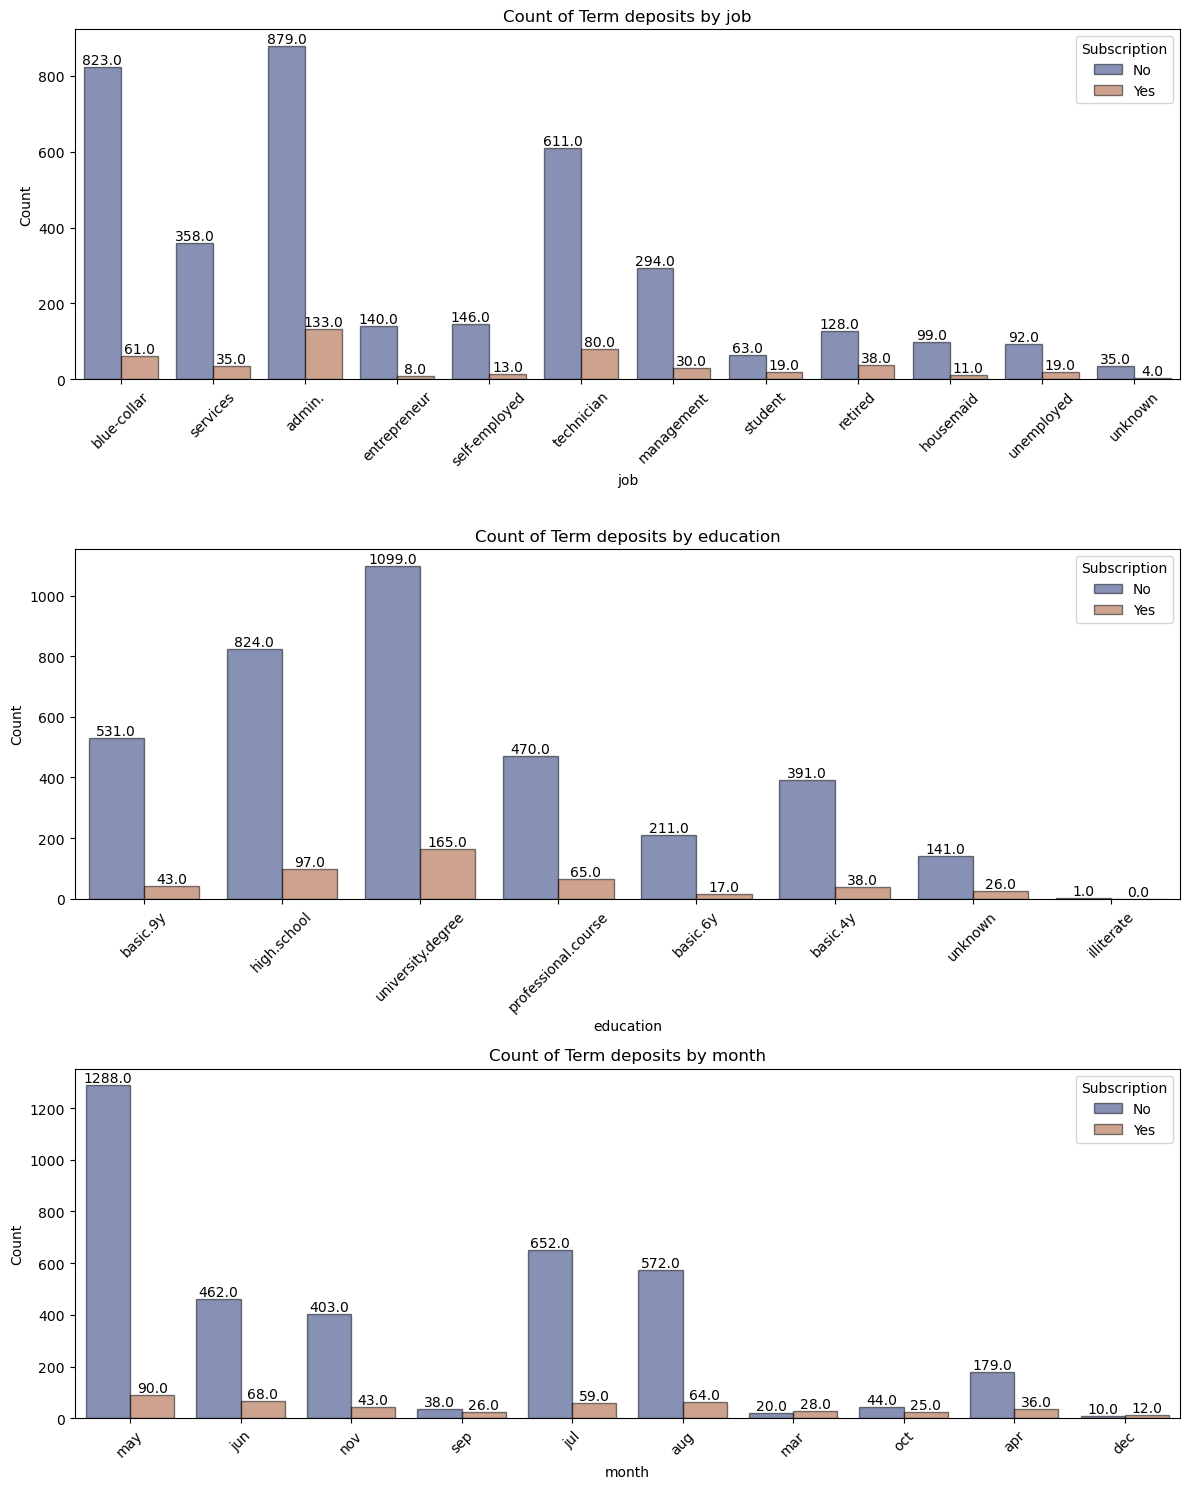

In [21]:
columns_for_countplt = ['marital', 'default', 'housing', 'loan', 'contact', 'day_of_week']

countplt_cols = 2
countplt_rows = math.ceil(len(columns_for_countplt)/countplt_cols)

plt.figure(figsize=(6 * countplt_cols, 5 * countplt_rows))

for i, column in enumerate(columns_for_countplt, start=1):
    plt.subplot(countplt_rows, countplt_cols, i)
    ax = sns.countplot(data=df, x=column, hue='y', palette='dark', edgecolor='black', alpha=0.5)
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.title(f'Count of Term deposits by {column}')
    # plt.xticks(rotation=30)
    plt.legend(title='Subscription', labels=['No', 'Yes'], bbox_to_anchor=(1, 1))

    for p in ax.patches:
        height = p.get_height()
        ax.annotate(text=height,xy=(p.get_x()+p.get_width()/2, height), ha='center', va='bottom')
plt.tight_layout()
plt.savefig('images/countplt_1_colums_vs_term_deposits.png')
plt.show()


columns_for_countplt = ['job', 'education', 'month']

countplt_cols = 1
countplt_rows = math.ceil(len(columns_for_countplt)/countplt_cols)

plt.figure(figsize=(12 * countplt_cols, 5 * countplt_rows))

for i, column in enumerate(columns_for_countplt, start=1):
    plt.subplot(countplt_rows, countplt_cols, i)
    ax = sns.countplot(data=df, x=column, hue='y', palette='dark', edgecolor='black', alpha=0.5)
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.title(f'Count of Term deposits by {column}')
    plt.xticks(rotation=45)
    plt.legend(title='Subscription', labels=['No', 'Yes'], bbox_to_anchor=(1, 1))

    for p in ax.patches:
        height = p.get_height()
        ax.annotate(text=height,xy=(p.get_x()+p.get_width()/2, height), ha='center', va='bottom')
plt.tight_layout()
plt.savefig('images/countplt_2_colums_vs_term_deposits.png')
plt.show()


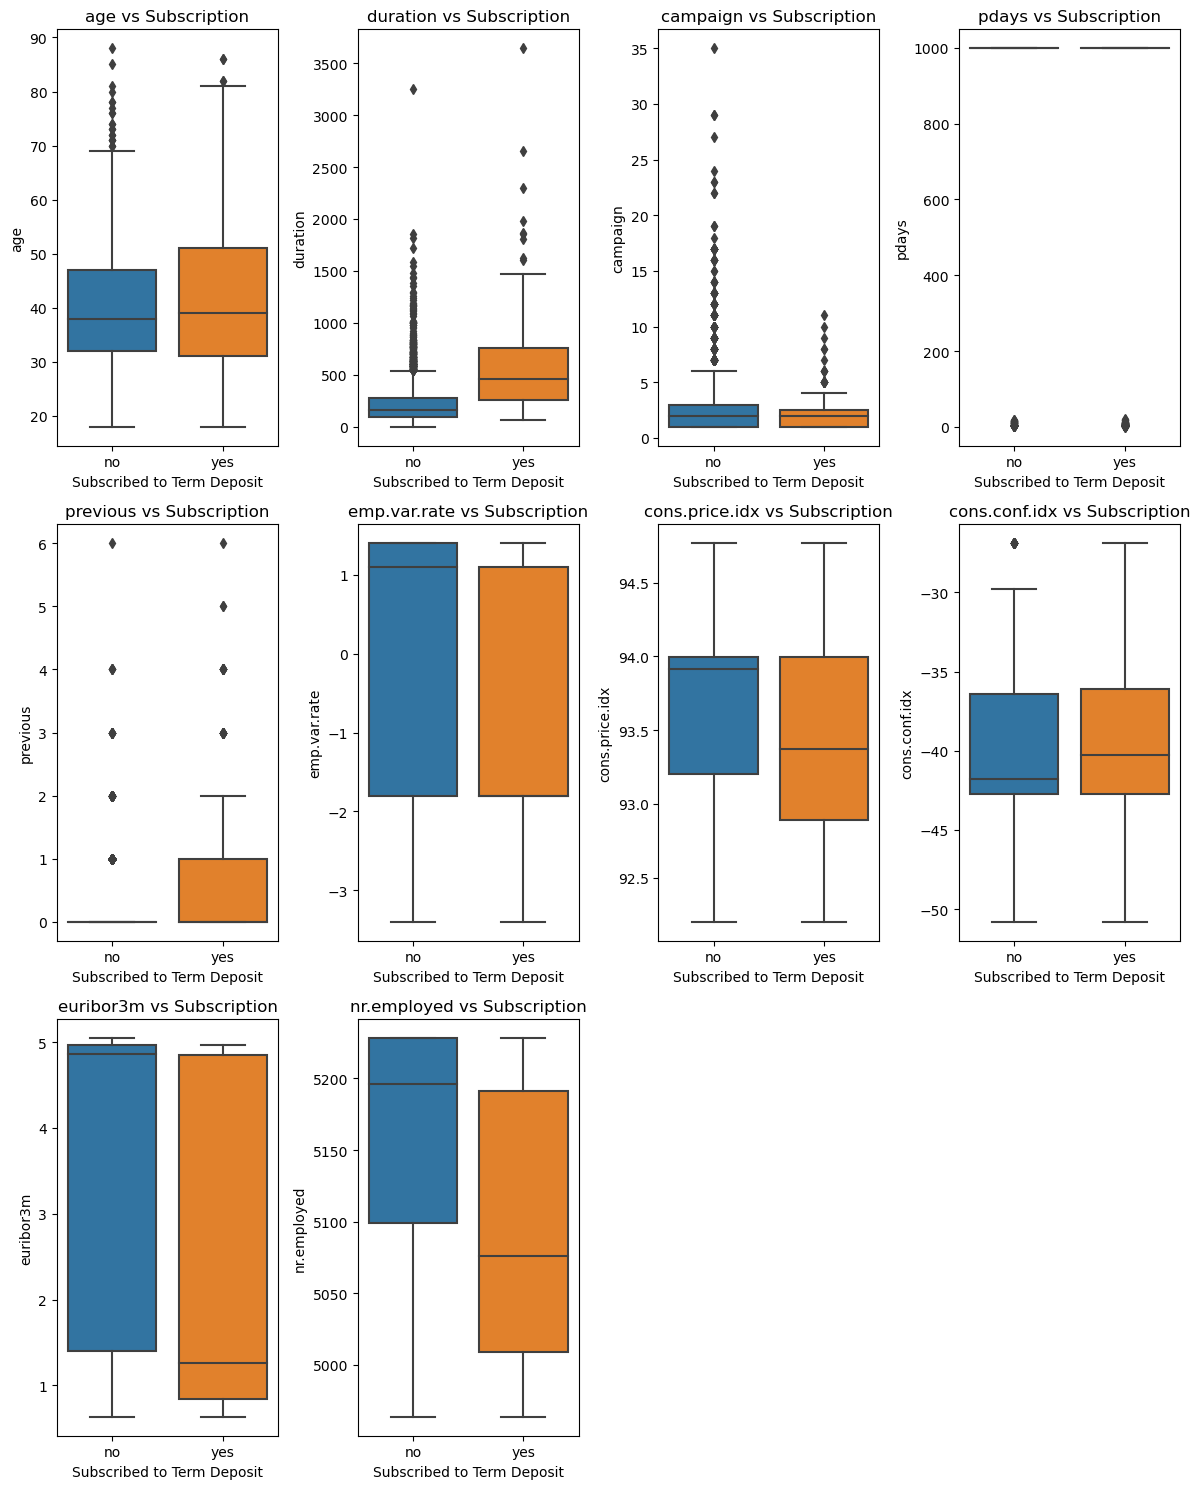

In [64]:
numerical_columns
box_plot_columns = 4
box_plot_rows = math.ceil(len(numerical_columns) / box_plot_columns)

plt.figure(figsize=(3*box_plot_columns, 5*box_plot_rows))
for i, column in enumerate(numerical_columns, start=1):
    plt.subplot(box_plot_rows, box_plot_columns, i)
    sns.boxplot(data=df, x='y', y=column)
    plt.title(f'{column} vs Subscription')
    plt.xlabel('Subscribed to Term Deposit')
    plt.ylabel(column)
plt.tight_layout()
plt.savefig('images/boxplot_numerical_columns_vs_term_deposit.png')
plt.show()

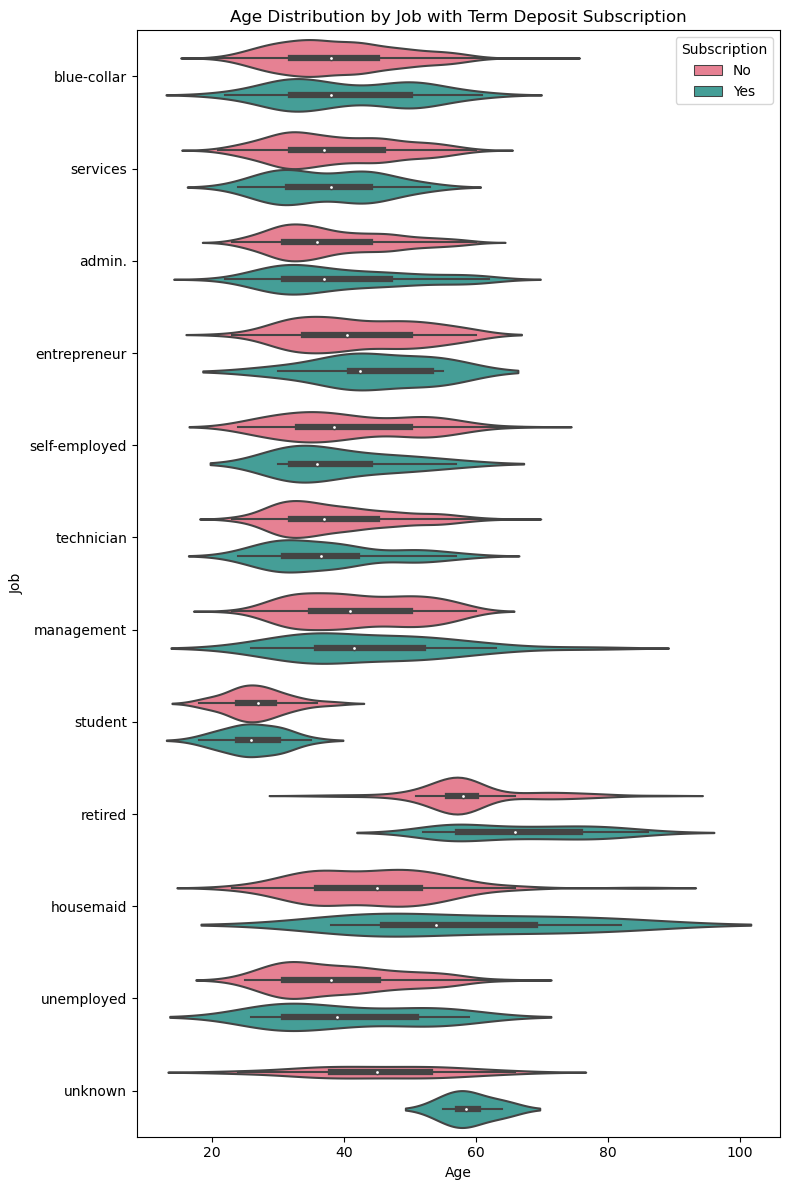

In [65]:
plt.figure(figsize=(8, 12))
violin_plot = sns.violinplot(data=df, x='age', y='job', hue='y', palette='husl')
plt.xlabel('Age')
plt.ylabel('Job')
plt.title('Age Distribution by Job with Term Deposit Subscription')
handles, labels = violin_plot.get_legend_handles_labels()
plt.legend(handles=handles, title='Subscription', loc='upper right', labels=['No', 'Yes'])
plt.tight_layout()
plt.savefig('images/violinplot_age_vs_job.png')
plt.show()

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4119 non-null   int64  
 1   job             4119 non-null   object 
 2   marital         4119 non-null   object 
 3   education       4119 non-null   object 
 4   default         4119 non-null   object 
 5   housing         4119 non-null   object 
 6   loan            4119 non-null   object 
 7   contact         4119 non-null   object 
 8   month           4119 non-null   object 
 9   day_of_week     4119 non-null   object 
 10  duration        4119 non-null   int64  
 11  campaign        4119 non-null   int64  
 12  pdays           4119 non-null   int64  
 13  previous        4119 non-null   int64  
 14  poutcome        4119 non-null   object 
 15  emp.var.rate    4119 non-null   float64
 16  cons.price.idx  4119 non-null   float64
 17  cons.conf.idx   4119 non-null   f

#### Business objective

Determine whether we can accurately classify a user, in a campaign, with a high probability that the user will subscribe to a term deposit.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4119 non-null   int64  
 1   job             4119 non-null   object 
 2   marital         4119 non-null   object 
 3   education       4119 non-null   object 
 4   default         4119 non-null   object 
 5   housing         4119 non-null   object 
 6   loan            4119 non-null   object 
 7   contact         4119 non-null   object 
 8   month           4119 non-null   object 
 9   day_of_week     4119 non-null   object 
 10  duration        4119 non-null   int64  
 11  campaign        4119 non-null   int64  
 12  pdays           4119 non-null   int64  
 13  previous        4119 non-null   int64  
 14  poutcome        4119 non-null   object 
 15  emp.var.rate    4119 non-null   float64
 16  cons.price.idx  4119 non-null   float64
 17  cons.conf.idx   4119 non-null   f

#### Impute columns with 'unknown' data

In [68]:
columns_to_impute = ['job', 'marital', 'education', 'default', 'housing', 'loan']

In [69]:
df.replace('unknown', np.nan, inplace=True)

In [70]:
imputer = SimpleImputer(strategy='most_frequent')

for column in df.columns:
    df[column] = imputer.fit_transform(df[[column]]).ravel()


In [71]:
df.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,487,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,346,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,227,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no


In [72]:
df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

#### Drop duration
the duration is not known before a call is performed. Also, after the end of the call y is obviously known.

In [73]:
if 'duration' in df.columns:
    df.drop(columns=['duration'], inplace=True)

#### Convert 'y' to int

In [74]:
df['y'].replace({'yes': 1, 'no': 0}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4119 non-null   int64  
 1   job             4119 non-null   object 
 2   marital         4119 non-null   object 
 3   education       4119 non-null   object 
 4   default         4119 non-null   object 
 5   housing         4119 non-null   object 
 6   loan            4119 non-null   object 
 7   contact         4119 non-null   object 
 8   month           4119 non-null   object 
 9   day_of_week     4119 non-null   object 
 10  campaign        4119 non-null   int64  
 11  pdays           4119 non-null   int64  
 12  previous        4119 non-null   int64  
 13  poutcome        4119 non-null   object 
 14  emp.var.rate    4119 non-null   float64
 15  cons.price.idx  4119 non-null   float64
 16  cons.conf.idx   4119 non-null   float64
 17  euribor3m       4119 non-null   f

#### Encoding

Using OneHotEncoder on non-numerical columns job, marital, education, housing, loan, contact, month, day_of_week

In [75]:
selector = make_column_selector(dtype_include=object)


In [76]:
transformer = make_column_transformer(
    (OneHotEncoder(drop = 'first', handle_unknown='ignore'), selector),
    remainder = StandardScaler()
)
# transformer = ColumnTransformer(
#     transformers=[('oe', OrdinalEncoder(), oe_columns)],
#     remainder=StandardScaler())

In [77]:
transformer

ColumnTransformer(remainder=StandardScaler(),
                  transformers=[('onehotencoder',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x15c9224d0>)])

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [78]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('y', axis=1),
    df.y,
    test_size=0.3,
    random_state=25,
    stratify=df.y
)

In [79]:
X_train.shape

(2883, 19)

In [80]:
X_test.shape

(1236, 19)

In [81]:
y_train.shape

(2883,)

In [82]:
y_test.shape

(1236,)

In [83]:
y_train.head(5)

2781    0
2189    0
421     0
2060    0
3091    0
Name: y, dtype: int64

In [84]:
model_performance_df = pd.DataFrame(columns=['Model', 'Train Time', 'Train Accuracy', 'Test Accuracy', 'Train Recall', 'Test Recall', 'Train Precision', 'Test Precision', 'Train F1', 'Test F1'])


In [85]:
# Append model performance metrics to the DataFrame for the given model and return the updated DataFrame and also y_pred.
def model_performance_df_concat(model_name, train_time, model, perf_df):
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    return pd.concat(
    [perf_df,
     pd.DataFrame([{
        'Model': model_name,
        'Train Time': train_time,
        'Train Accuracy': accuracy_score(y_train, y_train_pred),
        'Test Accuracy': accuracy_score(y_test, y_pred),
        'Train Recall': recall_score(y_train, y_train_pred),
        'Test Recall': recall_score(y_test, y_pred),
        'Train Precision': precision_score(y_train, y_train_pred),
        'Test Precision': precision_score(y_test, y_pred),
        'Train F1': f1_score(y_train, y_train_pred),
        'Test F1': f1_score(y_test, y_pred)
        }])
    ],
    ignore_index=True
    ), y_pred

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [86]:
# Establishing the baseline: most frequent class
baseline = y_train.value_counts(normalize=True)[0]
baseline

0.8903919528269164

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [88]:
%%time
logistic_simple_pipe = Pipeline(steps=[
    ('transform', transformer),
    ('model', LogisticRegression(random_state=25, max_iter=1000, n_jobs=-1))
])
logistic_simple_pipe
start_time = time.time()
logistic_simple_pipe.fit(X_train, y_train)
train_time = time.time() - start_time
y_proba_logistic_simple = logistic_simple_pipe.predict_proba(X_test)[:, 1]

CPU times: user 225 ms, sys: 211 ms, total: 436 ms
Wall time: 528 ms


In [89]:
model_performance_df, y_pred = model_performance_df_concat("Logistic", train_time, logistic_simple_pipe, model_performance_df)

In [90]:
model_performance_df

,Model,Train Time,Train Accuracy,Test Accuracy,Train Recall,Test Recall,Train Precision,Test Precision,Train F1,Test F1
0,Logistic,0.519693,0.902879,0.908576,0.240506,0.251852,0.655172,0.73913,0.351852,0.375691


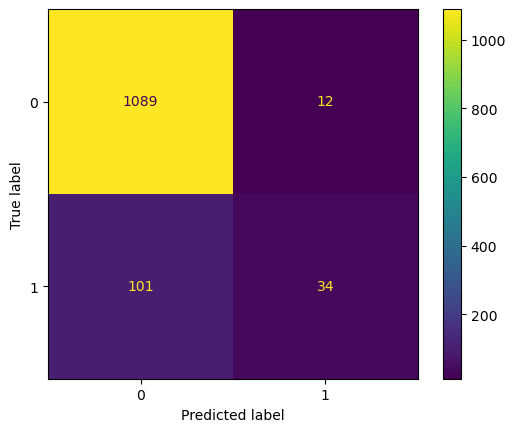

In [91]:
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot()
plt.savefig('images/confusion_matrix_Logistic.png')
plt.show()

### Problem 9: Score the Model

What is the accuracy of your model?

The accuracy of simple LogisticRegression model I got is 0.9011 while for dummy/baseline model is 0.8873.

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

### simple KNN

In [93]:
%%time
knn_simple_pipe = Pipeline(steps=[
    ('transform', transformer),
    ('model', KNeighborsClassifier())
])
knn_simple_pipe
start_time = time.time()
knn_simple_pipe.fit(X_train, y_train)
train_time = time.time() - start_time
y_proba_knn_simple = knn_simple_pipe.predict_proba(X_test)[:, 1]

CPU times: user 375 ms, sys: 75.5 ms, total: 451 ms
Wall time: 143 ms


In [94]:
model_performance_df, y_pred = model_performance_df_concat("KNN", train_time, knn_simple_pipe, model_performance_df)

In [95]:
model_performance_df

,Model,Train Time,Train Accuracy,Test Accuracy,Train Recall,Test Recall,Train Precision,Test Precision,Train F1,Test F1
0,Logistic,0.519693,0.902879,0.908576,0.240506,0.251852,0.655172,0.739130,0.351852,0.375691
1,KNN,0.020142,0.912591,0.889968,0.332278,0.207407,0.719178,0.491228,0.454545,0.291667


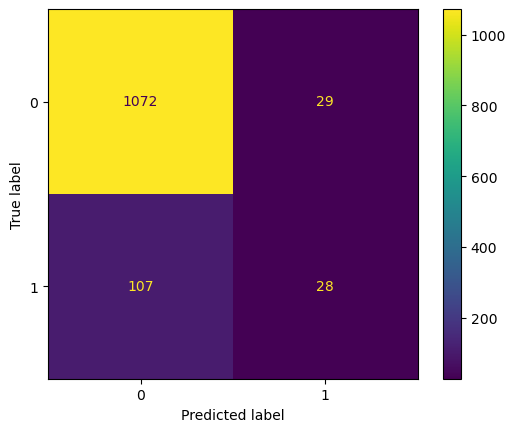

In [96]:
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot()
plt.savefig('images/confusion_matrix_KNN.png')
plt.show()

#### Simple Decision Tree

In [97]:
%%time
dtree_simple_pipe = Pipeline(steps=[('transform', transformer), ('model', DecisionTreeClassifier(random_state=25))])
dtree_simple_pipe
start_time = time.time()
dtree_simple_pipe.fit(X_train, y_train)
train_time = time.time() - start_time
y_proba_dtree_simple = dtree_simple_pipe.predict_proba(X_test)[:, 1]

CPU times: user 47.3 ms, sys: 4.36 ms, total: 51.7 ms
Wall time: 50.6 ms


In [98]:
model_performance_df, y_pred = model_performance_df_concat('DecisionTree', train_time, dtree_simple_pipe, model_performance_df)

In [99]:
model_performance_df

,Model,Train Time,Train Accuracy,Test Accuracy,Train Recall,Test Recall,Train Precision,Test Precision,Train F1,Test F1
0,Logistic,0.519693,0.902879,0.908576,0.240506,0.251852,0.655172,0.739130,0.351852,0.375691
1,KNN,0.020142,0.912591,0.889968,0.332278,0.207407,0.719178,0.491228,0.454545,0.291667
2,DecisionTree,0.040505,0.999306,0.828479,0.993671,0.303704,1.000000,0.257862,0.996825,0.278912


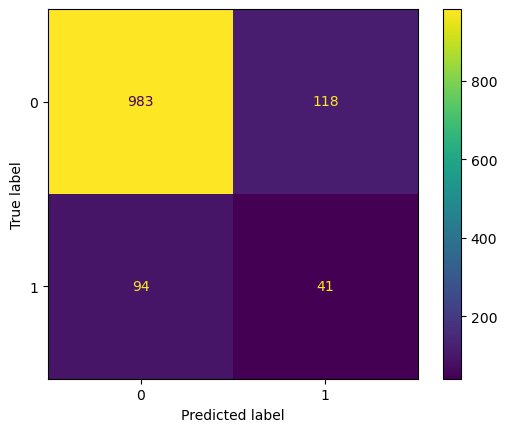

In [100]:
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm)
cm_display.plot()
plt.savefig('images/confusion_matrix_DecisionTree.png')
plt.show()

#### Simple SVM model

In [101]:
%%time
svm_simple_pipeline = Pipeline(steps=[('transform', transformer), ('model', SVC(random_state=25, probability=True))])
start_time = time.time()
svm_simple_pipeline.fit(X_train, y_train)
train_time = time.time() - start_time
y_proba_svm_simple = svm_simple_pipeline.predict_proba(X_test)[:, 1]

CPU times: user 1.67 s, sys: 18.8 ms, total: 1.69 s
Wall time: 1.83 s


In [102]:
model_performance_df, y_pred = model_performance_df_concat('SVC', train_time, svm_simple_pipeline, model_performance_df)

In [103]:
model_performance_df

,Model,Train Time,Train Accuracy,Test Accuracy,Train Recall,Test Recall,Train Precision,Test Precision,Train F1,Test F1
0,Logistic,0.519693,0.902879,0.908576,0.240506,0.251852,0.655172,0.739130,0.351852,0.375691
1,KNN,0.020142,0.912591,0.889968,0.332278,0.207407,0.719178,0.491228,0.454545,0.291667
2,DecisionTree,0.040505,0.999306,0.828479,0.993671,0.303704,1.000000,0.257862,0.996825,0.278912
3,SVC,1.560230,0.910163,0.902913,0.218354,0.177778,0.851852,0.727273,0.347607,0.285714


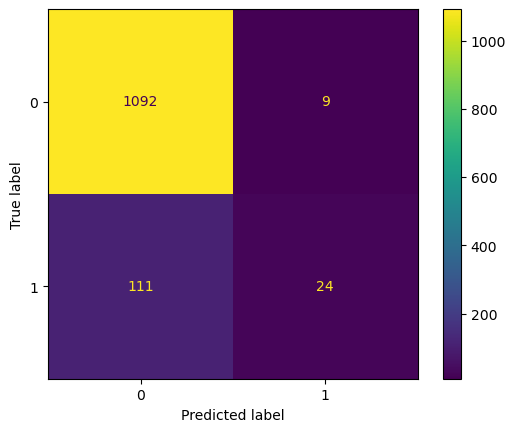

In [104]:
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm)
cm_display.plot()
plt.savefig('images/confusion_matrix_SVC.png')
plt.show()

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

#### Feature Engineering and Exploration

#### Hyperparameter tuning

In [105]:
# models = {
#     'LogisticRegression': {
#         'params': {
#             'model__C': [0.01, 0.1, 1, 3, 5, 7, 9, 11],
            
#         }
#     },
#     'KNeighborsClassifier': {
#         'params': {
#             'model__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19],
#             'model__weights': ['uniform', 'distance']
#         }
#     },
#     'DecisionTreeClassifier': {
#         'params': {
#             'model__max_depth': [3, 5, 7, 9, 11, 13, 15, 17],
#             'model__criterion': ['gini', 'entropy'],
#             'model__min_samples_split': [2, 3, 4, 5, 6],
#             'model__min_samples_leaf': [1, 2, 3, 4, 5]
#         }
#     },
#     'SVC': {
#         'params': {
#             'model__C': [0.01, 0.1, 1, 3, 5, 7, 9, 11],
#             'model__gamma': [0.01, 0.1, 1, 3, 5, 7, 11, 13, 15],
#             'model__kernel': ['linear', 'rbf', 'poly', 'sigmoid']
#         }
#     }
# }

models = {
    'LogisticRegression': {
        'params': {
            'model__C': [0.01, 0.1, 1, 3, 5],
            
        }
    },
    'KNeighborsClassifier': {
        'params': {
            'model__n_neighbors': [3, 7, 11, 15],
            'model__weights': ['uniform', 'distance']
        }
    },
    'DecisionTreeClassifier': {
        'params': {
            'model__max_depth': [1, 5, 9, 13],
            'model__criterion': ['gini', 'entropy'],
            'model__min_samples_split': [2, 3, 4, 5],
            'model__min_samples_leaf': [1, 2, 3, 4]
        }
    },
    'SVC': {
        'params': {
            'model__C': [0.1, 3, 7, 11],
            'model__gamma': [0.01, 0.1, 3],
            'model__kernel': ['linear', 'rbf', 'poly', 'sigmoid']
        }
    }
}

# scoring = {'accuracy': accuracy_score, 'recall': recall_score, 'precision': precision_score, 'f1': f1_score}
# scoring = {'accuracy': accuracy_score, 'recall': recall_score, 'precision': precision_score, 'f1': f1_score}

##### LogisticRegression

/Users/gvalleru/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gvalleru/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gvalleru/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gvalleru/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gvalleru/anaconda3/lib/python3.11/site-packag

Pipeline(steps=[('transform',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x15ca46090>)])),
                ('model',
                 LogisticRegression(C=3, max_iter=5000, random_state=25))])


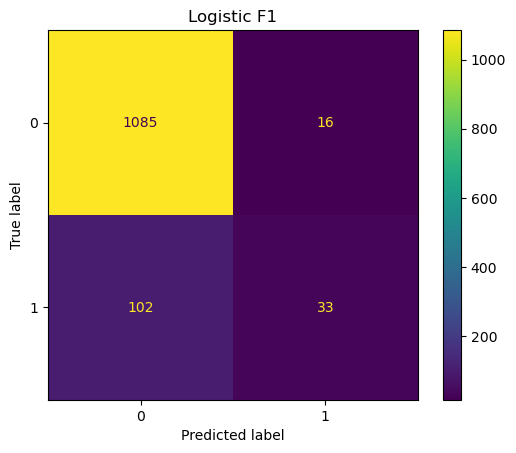

CPU times: user 1.08 s, sys: 308 ms, total: 1.39 s
Wall time: 2.83 s


In [106]:
%%time

logistic_grid_pipe = Pipeline(steps=[
    ('transform', transformer),
    ('model', LogisticRegression(random_state=25, max_iter=5000))
])

logistic_grid = GridSearchCV(
    estimator=logistic_grid_pipe,
    param_grid=models['LogisticRegression']['params'],
    cv=5,
    n_jobs=-1,
    scoring=make_scorer(f1_score)
)
start_time = time.time()
logistic_grid.fit(X_train, y_train)
end_time = time.time()
y_proba_logistic_grid = logistic_grid.predict_proba(X_test)[:, 1]
print(logistic_grid.best_estimator_)
train_time = (end_time - start_time) / logistic_grid.cv_results_['mean_fit_time'].shape[0]
model_performance_df, y_pred = model_performance_df_concat(f'Logistic F1', train_time, logistic_grid, model_performance_df)
cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
cm_display.plot()
plt.title(f'Logistic F1')
plt.savefig(f'images/Logistic_F1.png')
plt.show()

In [107]:
model_performance_df

,Model,Train Time,Train Accuracy,Test Accuracy,Train Recall,Test Recall,Train Precision,Test Precision,Train F1,Test F1
0,Logistic,0.519693,0.902879,0.908576,0.240506,0.251852,0.655172,0.739130,0.351852,0.375691
1,KNN,0.020142,0.912591,0.889968,0.332278,0.207407,0.719178,0.491228,0.454545,0.291667
2,DecisionTree,0.040505,0.999306,0.828479,0.993671,0.303704,1.000000,0.257862,0.996825,0.278912
3,SVC,1.560230,0.910163,0.902913,0.218354,0.177778,0.851852,0.727273,0.347607,0.285714
4,Logistic F1,0.522171,0.901838,0.904531,0.237342,0.244444,0.641026,0.673469,0.346420,0.358696


##### KNeighborsClassifier 

/Users/gvalleru/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gvalleru/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gvalleru/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gvalleru/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gvalleru/anaconda3/lib/python3.11/site-packag

Pipeline(steps=[('transform',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x184b6fa50>)])),
                ('model',
                 KNeighborsClassifier(n_neighbors=15, weights='distance'))])


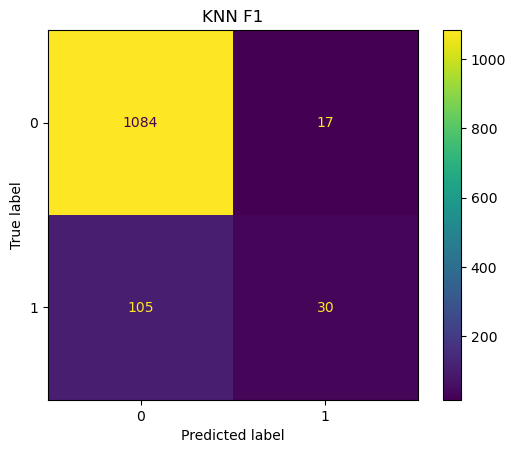

CPU times: user 1.89 s, sys: 128 ms, total: 2.02 s
Wall time: 817 ms


In [108]:
%%time
knn_grid_pipe = Pipeline(steps=[
    ('transform', transformer),
    ('model', KNeighborsClassifier())
])

knn_grid = GridSearchCV(
    estimator=knn_grid_pipe,
    param_grid=models['KNeighborsClassifier']['params'],
    cv=5,
    n_jobs=-1,
    scoring=make_scorer(f1_score)
)
start_time = time.time()
knn_grid.fit(X_train, y_train)
end_time = time.time()
y_proba_knn_grid = knn_grid.predict_proba(X_test)[:, 1]
print(knn_grid.best_estimator_)
train_time = (end_time - start_time) / knn_grid.cv_results_['mean_fit_time'].shape[0]
model_performance_df, y_pred = model_performance_df_concat(f'KNN F1', train_time, knn_grid, model_performance_df)
cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
cm_display.plot()
plt.title(f'KNN F1')
plt.savefig(f'images/KNN_F1.png')
plt.show()

In [109]:
model_performance_df

,Model,Train Time,Train Accuracy,Test Accuracy,Train Recall,Test Recall,Train Precision,Test Precision,Train F1,Test F1
0,Logistic,0.519693,0.902879,0.908576,0.240506,0.251852,0.655172,0.739130,0.351852,0.375691
1,KNN,0.020142,0.912591,0.889968,0.332278,0.207407,0.719178,0.491228,0.454545,0.291667
2,DecisionTree,0.040505,0.999306,0.828479,0.993671,0.303704,1.000000,0.257862,0.996825,0.278912
3,SVC,1.560230,0.910163,0.902913,0.218354,0.177778,0.851852,0.727273,0.347607,0.285714
4,Logistic F1,0.522171,0.901838,0.904531,0.237342,0.244444,0.641026,0.673469,0.346420,0.358696
5,KNN F1,0.065956,0.999306,0.901294,0.993671,0.222222,1.000000,0.638298,0.996825,0.329670


##### Decision Tree

/Users/gvalleru/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gvalleru/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gvalleru/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gvalleru/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gvalleru/anaconda3/lib/python3.11/site-packag

Pipeline(steps=[('transform',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x184c9f110>)])),
                ('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=9))])


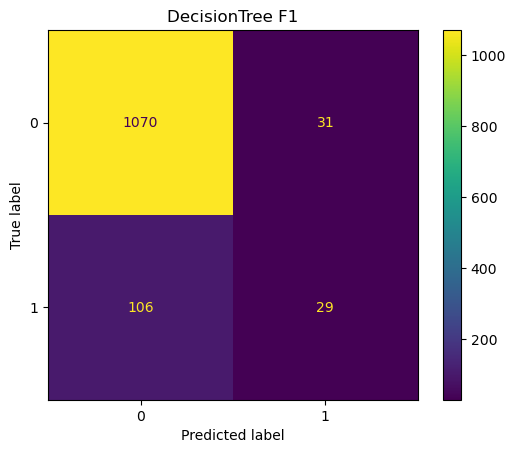

CPU times: user 1.74 s, sys: 171 ms, total: 1.91 s
Wall time: 3.99 s


In [110]:
%%time
dtree_grid_pipe = Pipeline(steps=[
    ('transform', transformer),
    ('model', DecisionTreeClassifier())
])


dtree_grid = GridSearchCV(
    estimator=dtree_grid_pipe,
    param_grid=models['DecisionTreeClassifier']['params'],
    cv=5,
    n_jobs=-1,
    scoring=make_scorer(f1_score)
)
start_time = time.time()
dtree_grid.fit(X_train, y_train)
end_time = time.time()
y_proba_dtree_grid = dtree_grid.predict_proba(X_test)[:, 1]
print(dtree_grid.best_estimator_)
train_time = (end_time - start_time) / dtree_grid.cv_results_['mean_fit_time'].shape[0]
model_performance_df, y_pred = model_performance_df_concat(f'DecisionTree F1', train_time, dtree_grid, model_performance_df)
cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
cm_display.plot()
plt.title(f'DecisionTree F1')
plt.savefig(f'images/DecisionTree_F1.png')
plt.show()

In [111]:
model_performance_df

,Model,Train Time,Train Accuracy,Test Accuracy,Train Recall,Test Recall,Train Precision,Test Precision,Train F1,Test F1
0,Logistic,0.519693,0.902879,0.908576,0.240506,0.251852,0.655172,0.739130,0.351852,0.375691
1,KNN,0.020142,0.912591,0.889968,0.332278,0.207407,0.719178,0.491228,0.454545,0.291667
2,DecisionTree,0.040505,0.999306,0.828479,0.993671,0.303704,1.000000,0.257862,0.996825,0.278912
3,SVC,1.560230,0.910163,0.902913,0.218354,0.177778,0.851852,0.727273,0.347607,0.285714
4,Logistic F1,0.522171,0.901838,0.904531,0.237342,0.244444,0.641026,0.673469,0.346420,0.358696
5,KNN F1,0.065956,0.999306,0.901294,0.993671,0.222222,1.000000,0.638298,0.996825,0.329670
6,DecisionTree F1,0.029450,0.940340,0.889159,0.481013,0.214815,0.950000,0.483333,0.638655,0.297436


##### SVC

In [112]:
%%time
svc_grid_pipe = Pipeline(steps=[
    ('transform', transformer),
    ('model', SVC(random_state=25, probability=True))
])

svc_grid = GridSearchCV(
    estimator=svc_grid_pipe,
    param_grid=models['SVC']['params'],
    cv=5,
    n_jobs=-1,
    scoring=make_scorer(f1_score)
)
start_time = time.time()
svc_grid.fit(X_train, y_train)
end_time = time.time()


/Users/gvalleru/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gvalleru/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gvalleru/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gvalleru/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/gvalleru/anaconda3/lib/python3.11/site-packag

CPU times: user 2.25 s, sys: 106 ms, total: 2.36 s
Wall time: 5min 27s


Pipeline(steps=[('transform',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x184cf2ad0>)])),
                ('model',
                 SVC(C=3, gamma=0.1, kernel='poly', probability=True,
                     random_state=25))])


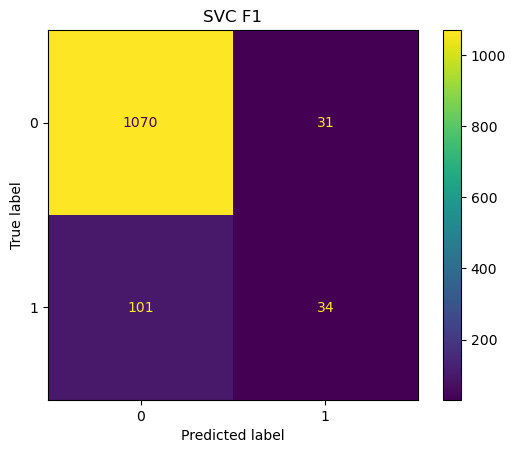

In [113]:
y_proba_svc_grid = svc_grid.predict_proba(X_test)[:, 1]
print(svc_grid.best_estimator_)
train_time = (end_time - start_time) / svc_grid.cv_results_['mean_fit_time'].shape[0]
model_performance_df, y_pred = model_performance_df_concat(f'SVC F1', train_time, svc_grid, model_performance_df)
cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
cm_display.plot()
plt.title(f'SVC F1')
plt.savefig(f'images/SVC_F1.png')
plt.show()

In [114]:
model_performance_df

,Model,Train Time,Train Accuracy,Test Accuracy,Train Recall,Test Recall,Train Precision,Test Precision,Train F1,Test F1
0,Logistic,0.519693,0.902879,0.908576,0.240506,0.251852,0.655172,0.739130,0.351852,0.375691
1,KNN,0.020142,0.912591,0.889968,0.332278,0.207407,0.719178,0.491228,0.454545,0.291667
2,DecisionTree,0.040505,0.999306,0.828479,0.993671,0.303704,1.000000,0.257862,0.996825,0.278912
3,SVC,1.560230,0.910163,0.902913,0.218354,0.177778,0.851852,0.727273,0.347607,0.285714
4,Logistic F1,0.522171,0.901838,0.904531,0.237342,0.244444,0.641026,0.673469,0.346420,0.358696
5,KNN F1,0.065956,0.999306,0.901294,0.993671,0.222222,1.000000,0.638298,0.996825,0.329670
6,DecisionTree F1,0.029450,0.940340,0.889159,0.481013,0.214815,0.950000,0.483333,0.638655,0.297436
7,SVC F1,6.816899,0.951093,0.893204,0.556962,0.251852,0.994350,0.523077,0.713996,0.340000


In [149]:
metrics = ['Train Time', 'Test Accuracy', 'Test Recall', 'Test Precision', 'Test F1']


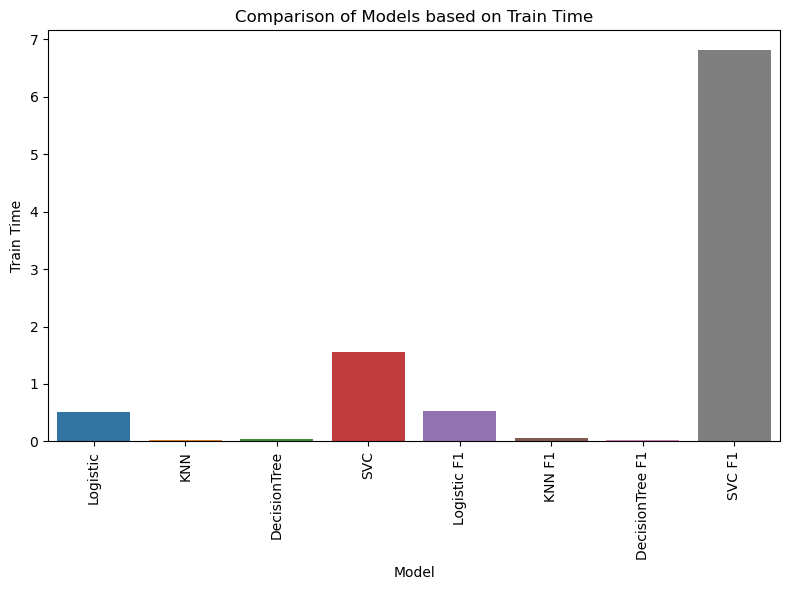

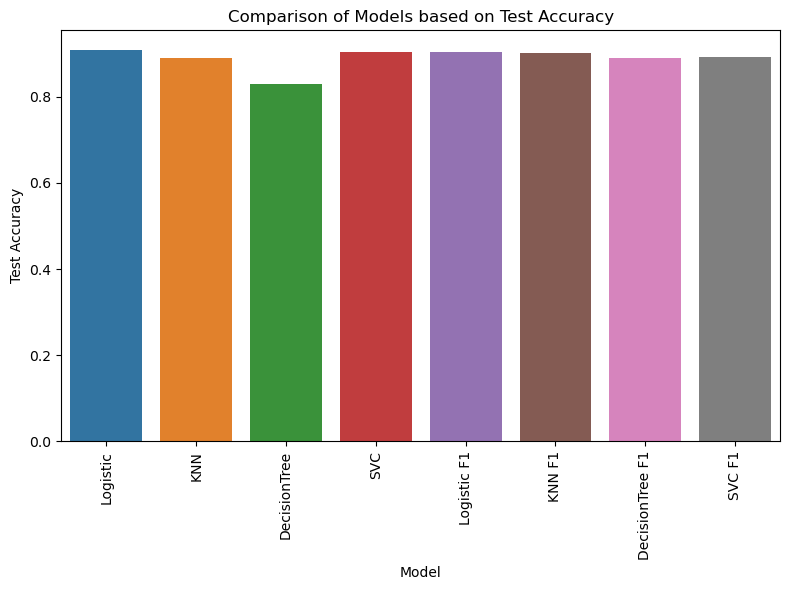

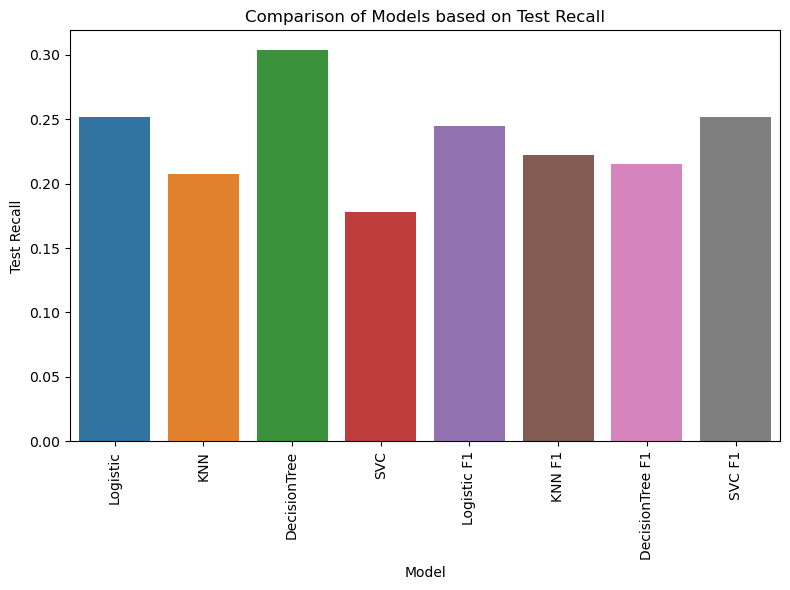

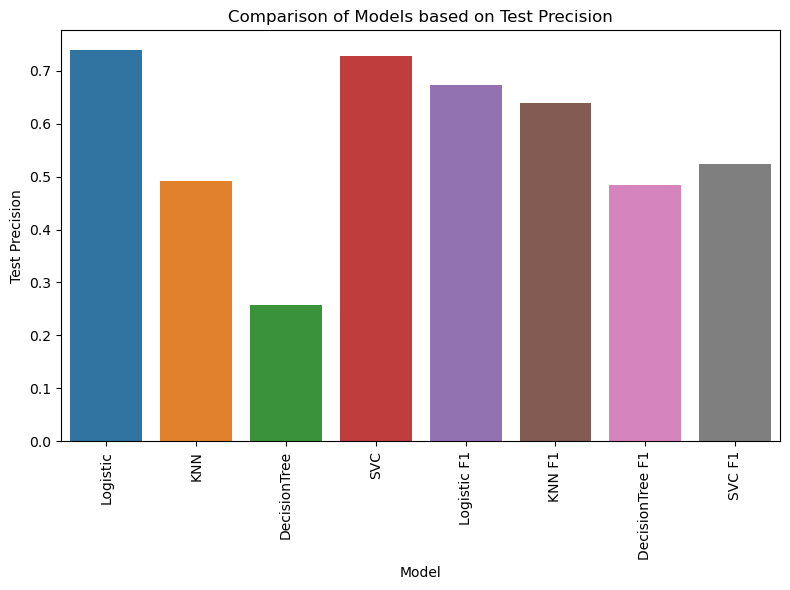

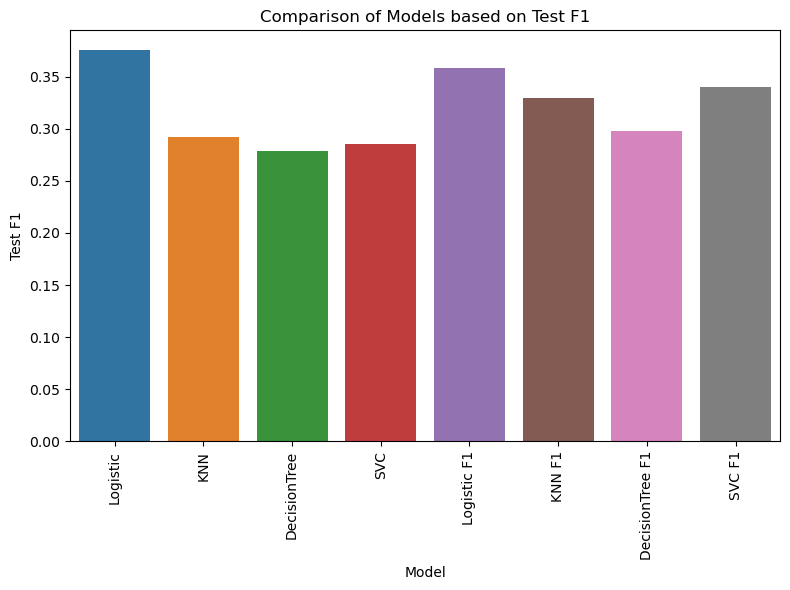

In [164]:
for metric in metrics:
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Model', y=metric, data=model_performance_df)
    plt.title(f'Comparison of Models based on {metric}')
    plt.xticks(rotation=90)
    plt.ylabel(metric)
    plt.tight_layout()
    plt.savefig(f'images/models_comp_by_{metric.lower().replace(" ", "_")}')
    plt.show()


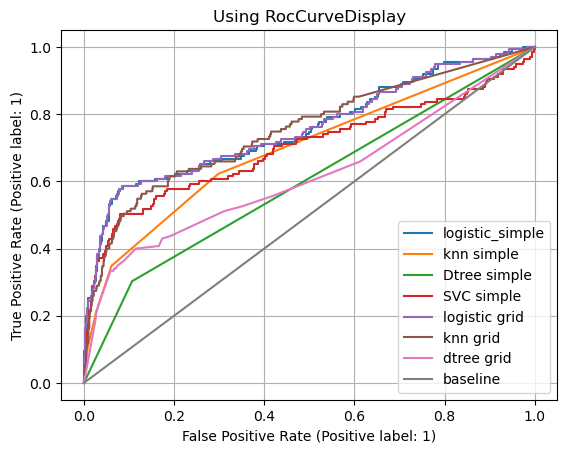

In [151]:
fig, ax = plt.subplots()
RocCurveDisplay.from_estimator(logistic_simple_pipe, X_test, y_test, ax = ax, label = 'logistic_simple')
RocCurveDisplay.from_estimator(knn_simple_pipe, X_test, y_test, ax = ax, label = 'knn simple')
RocCurveDisplay.from_estimator(dtree_simple_pipe, X_test, y_test, ax = ax, label = 'Dtree simple')
RocCurveDisplay.from_estimator(svm_simple_pipeline, X_test, y_test, ax = ax, label = 'SVC simple')
RocCurveDisplay.from_estimator(logistic_grid, X_test, y_test, ax = ax, label = 'logistic grid')
RocCurveDisplay.from_estimator(knn_grid, X_test, y_test, ax = ax, label = 'knn grid')
RocCurveDisplay.from_estimator(dtree_grid, X_test, y_test, ax = ax, label = 'dtree grid')

plt.grid()
plt.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), label = 'baseline');
plt.title('Using RocCurveDisplay')
plt.legend()
plt.savefig('images/roc_curve.png')
plt.show()

In [118]:
roc_auc_score(y_test, y_proba_logistic_simple)

0.757627745820298

In [119]:
roc_auc_score(y_test, y_proba_knn_simple)

0.6973222995929627

In [120]:
roc_auc_score(y_test, y_proba_dtree_simple)

0.5979479934066673

In [121]:
roc_auc_score(y_test, y_proba_svm_simple)

0.7011874726679449

In [122]:
roc_auc_score(y_test, y_proba_logistic_grid)

0.7581256097150739

In [123]:
roc_auc_score(y_test, y_proba_knn_grid)

0.7523059844585731

In [124]:
roc_auc_score(y_test, y_proba_dtree_grid)

0.616449692199011

In [152]:
roc_auc_score(y_test, y_proba_svc_grid)

0.6385037171594847

In [154]:
roc_areas = {
    'Model': ['Logistic Simple', 'KNN Simple', 'Decision Tree Simple', 'SVM Simple',
              'Logistic Grid', 'KNN Grid', 'Decision Tree Grid', 'SVC Grid'],
    'ROC AUC Score': [
        roc_auc_score(y_test, y_proba_logistic_simple),
        roc_auc_score(y_test, y_proba_knn_simple),
        roc_auc_score(y_test, y_proba_dtree_simple),
        roc_auc_score(y_test, y_proba_svm_simple),
        roc_auc_score(y_test, y_proba_logistic_grid),
        roc_auc_score(y_test, y_proba_knn_grid),
        roc_auc_score(y_test, y_proba_dtree_grid),
        roc_auc_score(y_test, y_proba_svc_grid)
    ]
}


In [155]:
roc_areas_df = pd.DataFrame(roc_areas)
roc_areas_df

,Model,ROC AUC Score
0,Logistic Simple,0.757628
1,KNN Simple,0.697322
2,Decision Tree Simple,0.597948
3,SVM Simple,0.701187
4,Logistic Grid,0.758126
5,KNN Grid,0.752306
6,Decision Tree Grid,0.616450
7,SVC Grid,0.638504


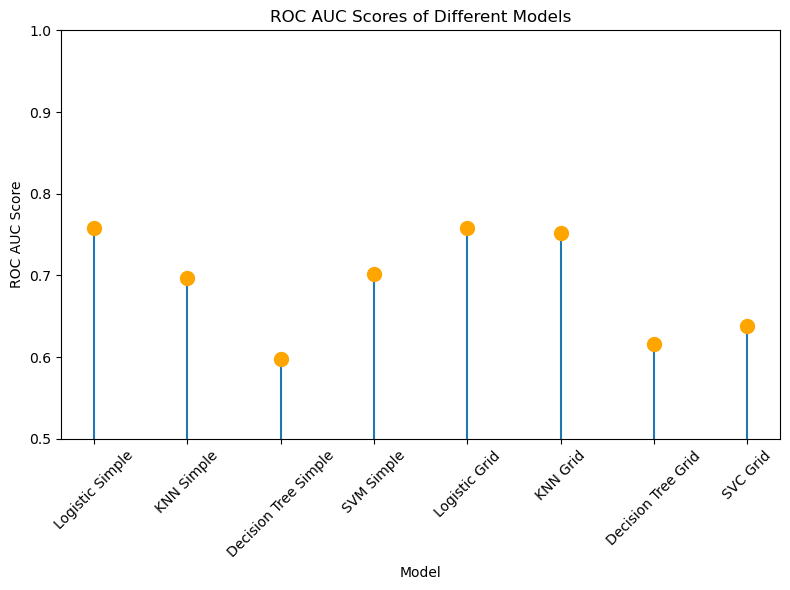

In [165]:
# Create lollipop chart
plt.figure(figsize=(8, 6))
plt.stem(roc_areas_df['Model'], roc_areas_df['ROC AUC Score'], basefmt=" ", use_line_collection=True)
plt.scatter(roc_areas_df['Model'], roc_areas_df['ROC AUC Score'], color='orange', s=100, zorder=3)
plt.xticks(rotation=45)
plt.title('ROC AUC Scores of Different Models')
plt.xlabel('Model')
plt.ylabel('ROC AUC Score')
plt.ylim(0.5, 1.0)  # Ensures that the y-axis starts from 0.5 to better visualize the differences
plt.tight_layout()
plt.savefig('images/ROC_AUC.png')
plt.show()


##### Questions

In [143]:
# Extract feature names
ohe_features = logistic_simple_pipe.named_steps['transform'].named_transformers_['onehotencoder'].get_feature_names_out(selector(df)).tolist()
remaining_features = df.drop('y', axis=1).select_dtypes(exclude=object).columns.tolist()
feature_names = ohe_features + remaining_features
feature_names

['job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'marital_married',
 'marital_single',
 'education_basic.6y',
 'education_basic.9y',
 'education_high.school',
 'education_illiterate',
 'education_professional.course',
 'education_university.degree',
 'housing_yes',
 'loan_yes',
 'contact_telephone',
 'month_aug',
 'month_dec',
 'month_jul',
 'month_jun',
 'month_mar',
 'month_may',
 'month_nov',
 'month_oct',
 'month_sep',
 'day_of_week_mon',
 'day_of_week_thu',
 'day_of_week_tue',
 'day_of_week_wed',
 'poutcome_nonexistent',
 'poutcome_success',
 'age',
 'campaign',
 'pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed']

In [144]:
# Extract coefficients
coefficients = logistic_simple_pipe.named_steps['model'].coef_[0]
coefficients

array([-0.31961331, -0.49578488, -0.33627677, -0.24515001, -0.45048376,
       -0.35053918, -0.31405865,  0.0693208 ,  0.1639774 ,  0.42792345,
        0.19412624,  0.40221627,  0.23222087, -0.03099283,  0.07380853,
       -0.13451065,  0.06357124,  0.04553404, -0.14035142,  0.03280451,
       -0.93718173, -0.07372335,  0.72473542, -0.01882215,  0.21295815,
        1.1844638 , -0.40146286, -0.52073806, -0.57938351, -0.34253811,
       -0.070057  ,  0.01097661, -0.01939449,  0.09285876,  0.63726638,
        0.58496515,  0.25946473, -0.17589136, -0.21352018,  0.05676185,
       -0.80669497,  0.51888883,  0.17693786, -0.03672561, -0.17229024])

In [145]:
# Create DataFrame for feature importances
feature_importances = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
feature_importances['Absolute Coefficient'] = feature_importances['Coefficient'].abs()



In [146]:
# Sort by absolute coefficient value
feature_importances = feature_importances.sort_values(by='Absolute Coefficient', ascending=False)

feature_importances

,Feature,Coefficient,Absolute Coefficient
25,month_mar,1.184464,1.184464
20,contact_telephone,-0.937182,0.937182
40,emp.var.rate,-0.806695,0.806695
22,month_dec,0.724735,0.724735
34,poutcome_nonexistent,0.637266,0.637266
35,poutcome_success,0.584965,0.584965
28,month_oct,-0.579384,0.579384
27,month_nov,-0.520738,0.520738
41,cons.price.idx,0.518889,0.518889
1,job_entrepreneur,-0.495785,0.495785


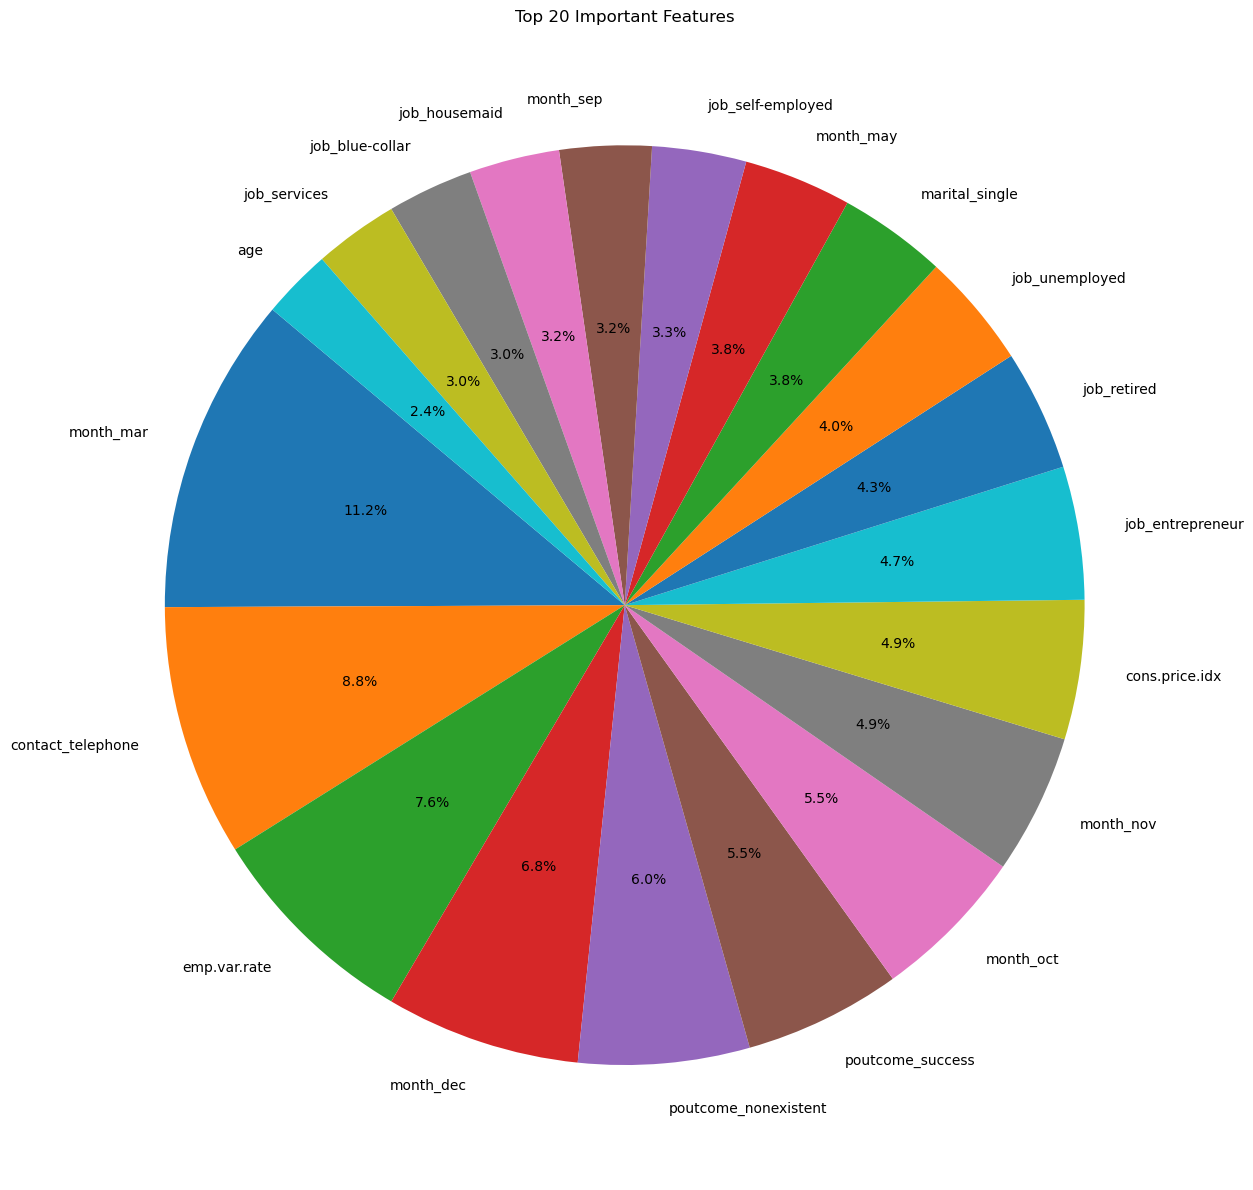

In [166]:
# Select top 5 features
top_5_features = feature_importances.head(20)

# Create a pie plot for the top 5 important features
plt.figure(figsize=(16, 12))
plt.pie(top_5_features['Absolute Coefficient'], labels=top_5_features['Feature'], autopct='%1.1f%%', startangle=140)
plt.title('Top 20 Important Features')
plt.tight_layout()
plt.savefig('images/feature_importances.png')
plt.show()
